## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 19: RNNs - Notebook 5: Sunspots

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import math
import seaborn as sns ; sns.set()

random_seed = 42

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def sum_of_mixed_sines(num_steps):
    values = [math.sin(12*t) * math.cos(t) + (math.sin(3*t) * math.sin(t/2.3)) \
              for t in np.linspace(0, 4 * np.pi, num_steps)]
    return np.array(values)

In [4]:
def get_sunspot_data():
    filename = 'data/Sunspots.txt'
    with open(filename) as f:
        content = f.readlines()
    data = [float(x.strip()) for x in content] 
    data = np.array(data)
    return data

In [5]:
def make_raw_data(training_length, test_length, data_source):
    if data_source == 'sines':
        X_train = sum_of_mixed_sines(training_length)
        X_test = sum_of_mixed_sines(test_length)
    else:
        data = get_sunspot_data()
        train_len = int(len(data) * training_length / (training_length + test_length))
        train_len = 2752
        X_train = data[:train_len]
        X_test = data[train_len:]
    return (X_train, X_test)

In [6]:
def samples_and_targets_from_sequence(sequence, window_size):
    '''Return lists of samples and targets built from overlapping
    windows of the given size. Windows start at the beginning of 
    the input sequence and move right by 1 element.'''
    samples = []
    targets = []
    for i in range(sequence.shape[0]-window_size):
        sample = sequence[i:i+window_size]
        target = sequence[i+window_size]
        samples.append(sample)
        targets.append(target[0]) 
    return (np.array(samples), np.array(targets))

In [7]:
def scale_sequences(training_sequence, test_sequence):
    # reshape train and test sequences to form needed by MinMaxScaler
    training_sequence = np.reshape(training_sequence, (training_sequence.shape[0], 1))
    test_sequence = np.reshape(test_sequence, (test_sequence.shape[0], 1))
    min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    min_max_scaler.fit(training_sequence)
    scaled_training_sequence = min_max_scaler.transform(training_sequence)
    scaled_test_sequence = min_max_scaler.transform(test_sequence)
    return (min_max_scaler, scaled_training_sequence, scaled_test_sequence)

In [8]:
def chop_up_sequences(training_sequence, test_sequence, window_size):
    (X_train, y_train) = samples_and_targets_from_sequence(training_sequence, window_size)
    (X_test, y_test) = samples_and_targets_from_sequence(test_sequence, window_size)
    return (X_train, y_train, X_test, y_test)

In [9]:
def make_data_set(window_size, training_length, data_source):
    testing_length = 0.5 * training_length
    train_seq, test_seq = make_raw_data(training_length, testing_length, data_source)
    min_max_scaler, scaled_train_seq, scaled_test_seq = scale_sequences(train_seq, test_seq)
    X_train, y_train, X_test, y_test = chop_up_sequences(scaled_train_seq, scaled_test_seq, window_size)
    return (min_max_scaler, X_train, y_train, X_test, y_test, train_seq, test_seq)

In [10]:
def plot_one_curve(data, title, linewidth=2, filename=None):
    plt.figure(figsize=(8,3))
    plt.plot(data, lw=linewidth)
    plt.title(title)
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

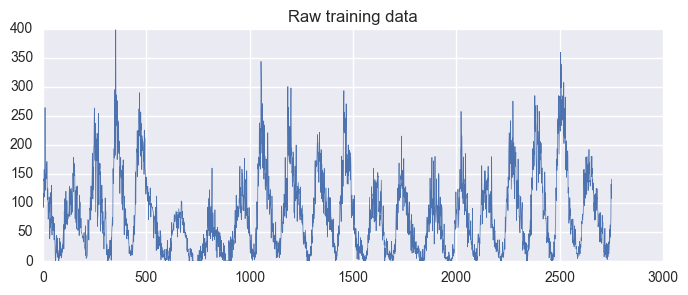

In [11]:
X_train, X_test = make_raw_data(500, 200, 'spots')
plot_one_curve(X_train, 'Raw training data', 0.5, 'spots_raw_training_data.png')

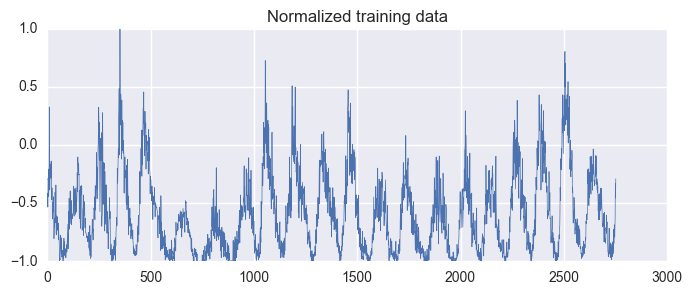

In [12]:
mmscaler, tr, te = scale_sequences(X_train, X_test)
plot_one_curve(tr, 'Normalized training data', 0.5, 'spots_normalized_training_data.png')

In [13]:
# build and run the first model. 
def make_rnn_model(units_list, window_size):
    model = Sequential()
    for i, num_units in enumerate(units_list):
        if i == 0:
            ret_seq = len(units_list) > 1
            model.add(LSTM(num_units, return_sequences = ret_seq, input_shape=[window_size, 1]))
        else:
            ret_seq = i != len(units_list)-1
            model.add(LSTM(num_units, return_sequences = ret_seq))

    model.add(Dense(1, activation=None))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [14]:
def make_dense_model(units_list, window_size):
    model = Sequential()
    for i in range(len(units_list)):
        if i==0:
            model.add(Dense(units_list[i], activation='linear', input_shape=[window_size]))
        else:
            model.add(Dense(units_list[i], activation='linear'))
        model.add(LeakyReLU(alpha=0.1))   
    model.add(Dense(1))

    model.compile(loss='mse', optimizer=RMSprop(0.001), metrics=['accuracy', 'mae', 'mse'])
    model.summary()
    return model

In [15]:
def build_and_show(model_type, data_source, units_list, window_size, training_length, 
                   epochs, linewidth=2, filename=None):
    np.random.seed(random_seed)
    min_max_scaler, X_train, y_train, X_test, y_test, train_data, test_data = \
        make_data_set(window_size, training_length, data_source)
    if model_type == 'RNN':
        model = make_rnn_model(units_list, window_size)
    else:
        model = make_dense_model(units_list, window_size)
        # data is made for RNN, so reshape
        X_train = np.reshape(X_train, X_train.shape[0:2])
        X_test = np.reshape(X_test, X_test.shape[0:2])
        
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=.001)
    history = model.fit(X_train, y_train, validation_split=0.33, epochs=epochs, batch_size=1, verbose=1, callbacks=[es])
    
    # Predict 
    y_train_predict = np.ravel(model.predict(X_train))
    y_test_predict = np.ravel(model.predict(X_test))
    
    # invert transformation
    inverse_y_train_predict = min_max_scaler.inverse_transform([y_train_predict])
    inverse_y_test_predict = min_max_scaler.inverse_transform([y_test_predict])  
    
    model_string = model_type+' '+str(units_list)
    
    plt.figure(figsize=(6,6))
    plt.plot(history.history['loss'], c='#c04f54', label='training loss')
    plt.plot(history.history['val_loss'], c='#5ca66a', label='validation loss')
    plt.title('Training loss, model '+model_string)
    plt.legend(loc='best')
    if filename is not None:
        plt.savefig('loss-'+filename, dpi=300, bbox_inches='tight')
    plt.show()
       
    plt.figure(figsize=(12, 4))
    
    zfar = 10
    znear = 20
    blue_color = '#4d74ae'
    orange_color = '#f6712a'
    
    plt.subplot(1, 2, 1)
    plt.plot(train_data, label="train", c=blue_color, linewidth=linewidth, zorder=zfar)
    skip_values = np.array(window_size*(np.nan,))
    flat_predict = np.ravel(inverse_y_train_predict)
    plot_predict = np.append(skip_values, flat_predict)
    plt.plot(plot_predict, label="train predict", c=orange_color, linewidth=linewidth, zorder=znear)
    plt.legend(loc='best')
    plt.title('Train, window '+str(window_size)+ ', model '+model_string)    
    
    plt.subplot(1, 2, 2)
    plt.plot(test_data, label="test", c=blue_color, linewidth=linewidth, zorder=zfar)
    skip_values = np.array(window_size*(np.nan,))
    flat_predict = np.ravel(inverse_y_test_predict)
    plot_predict = np.append(skip_values, flat_predict)
    plt.plot(plot_predict, label="test predict", c=orange_color, linewidth=linewidth, zorder=znear)
    plt.legend(loc='best')
    plt.title('Test, window '+str(window_size)+ ', model '+model_string) 
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3)                 60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Train on 1840 samples, validate on 907 samples
Epoch 1/50
1840/1840 [==============================] - 8s 4ms/step - loss: 0.0699 - acc: 0.0310 - val_loss: 0.0226 - val_acc: 0.0033
Epoch 2/50
1840/1840 [==============================] - 8s 4ms/step - loss: 0.0193 - acc: 0.0342 - val_loss: 0.0216 - val_acc: 0.0033
Epoch 3/50
1840/1840 [==============================] - 7s 4ms/step - loss: 0.0188 - acc: 0.0342 - val_loss: 0.0210 - val_acc: 0.0033
Epoch 4/50
1840/1840 [==============================] - 7s 4ms/step - loss: 0.0183 - acc: 0.0

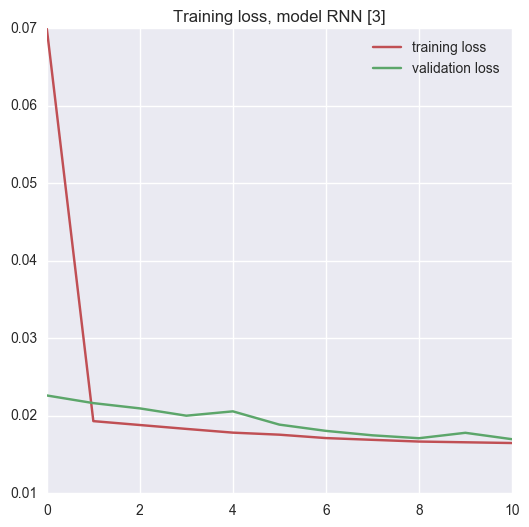

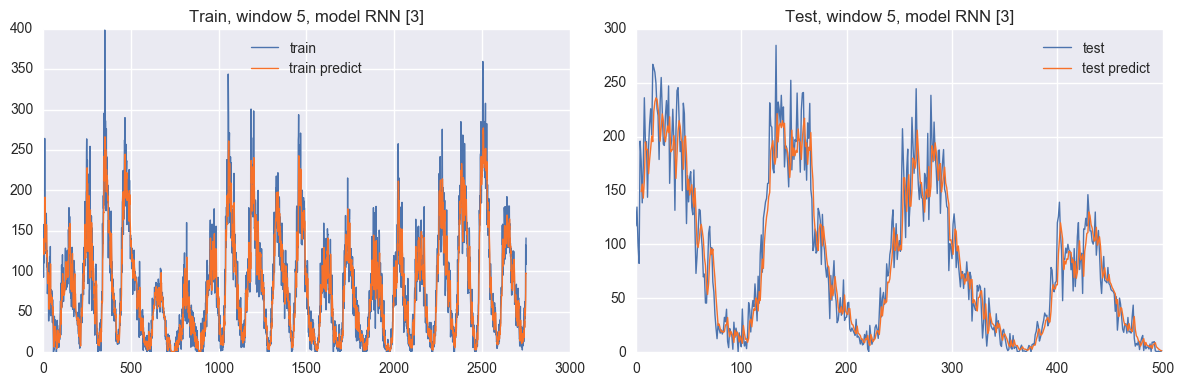

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 18        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
Train on 1840 samples, validate on 907 samples
Epoch 1/50
1840/1840 [==============================] - 2s 890us/step - loss: 0.0858 - acc: 0.0299 - mean_absolute_error: 0.1990 - mean_squared_error: 0.0858 - val_loss: 0.0229 - val_acc: 0.0033 - val_mean_absolute_error: 0.1108 - val_mean_squared_error: 0.0229
Epoch 2/50
1840/1840 [==============================] - 2s 824us/step - loss: 0.0213 - acc: 0.0342 - 

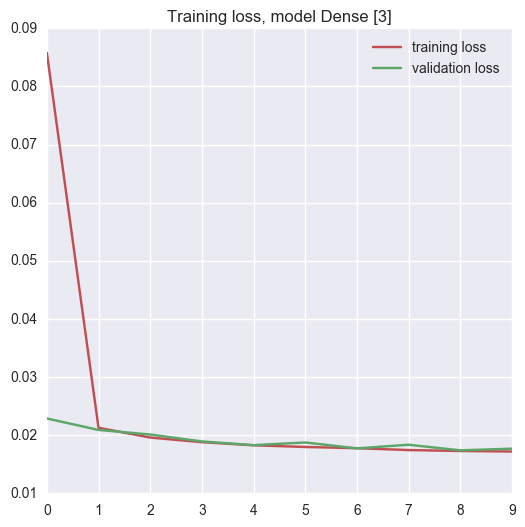

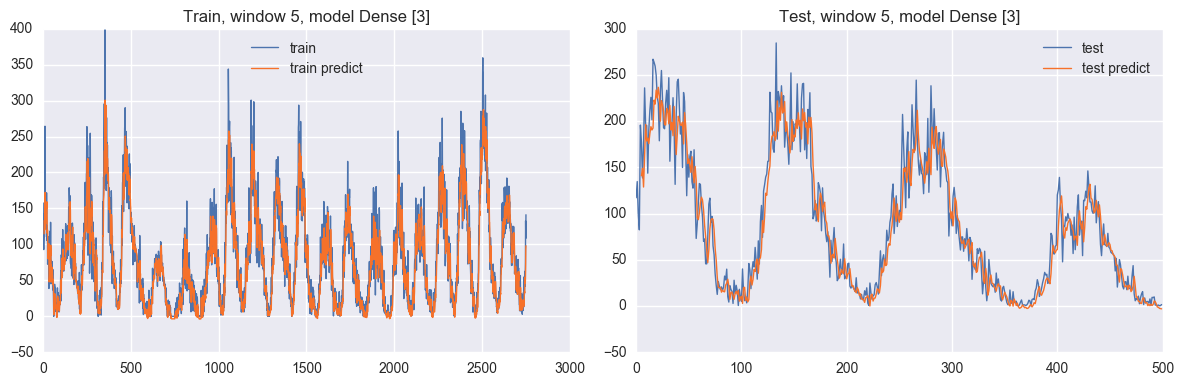

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3)                 60        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Train on 1810 samples, validate on 892 samples
Epoch 1/50
1810/1810 [==============================] - 49s 27ms/step - loss: 0.0790 - acc: 0.0309 - val_loss: 0.0328 - val_acc: 0.0034
Epoch 2/50
1810/1810 [==============================] - 48s 27ms/step - loss: 0.0235 - acc: 0.0348 - val_loss: 0.0242 - val_acc: 0.0034
Epoch 3/50
1810/1810 [==============================] - 48s 27ms/step - loss: 0.0190 - acc: 0.0348 - val_loss: 0.0199 - val_acc: 0.0034
Epoch 4/50
1810/1810 [==============================] - 48s 27ms/step - loss: 0.0167 - 

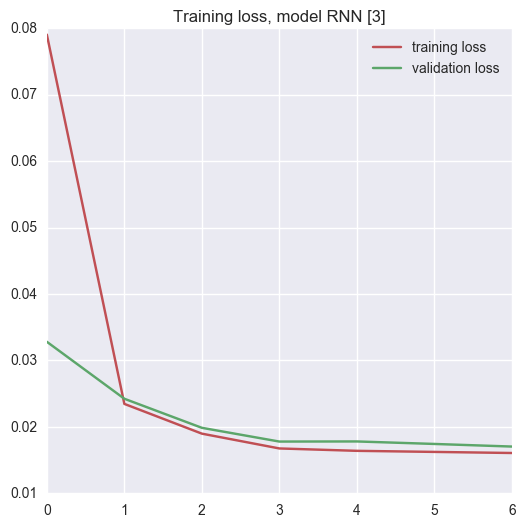

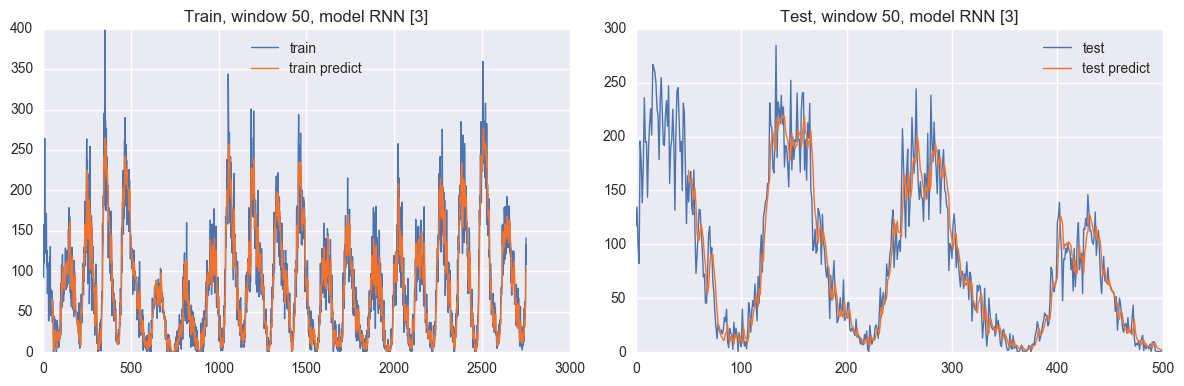

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 3)                 153       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________
Train on 1810 samples, validate on 892 samples
Epoch 1/50
1810/1810 [==============================] - 2s 928us/step - loss: 0.0503 - acc: 0.0348 - mean_absolute_error: 0.1732 - mean_squared_error: 0.0503 - val_loss: 0.0414 - val_acc: 0.0034 - val_mean_absolute_error: 0.1603 - val_mean_squared_error: 0.0414
Epoch 2/50
1810/1810 [==============================] - 1s 722us/step - loss: 0.0267 - acc: 0.0348 

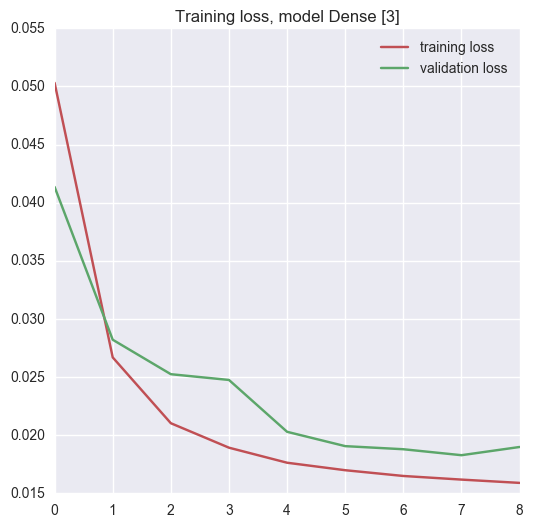

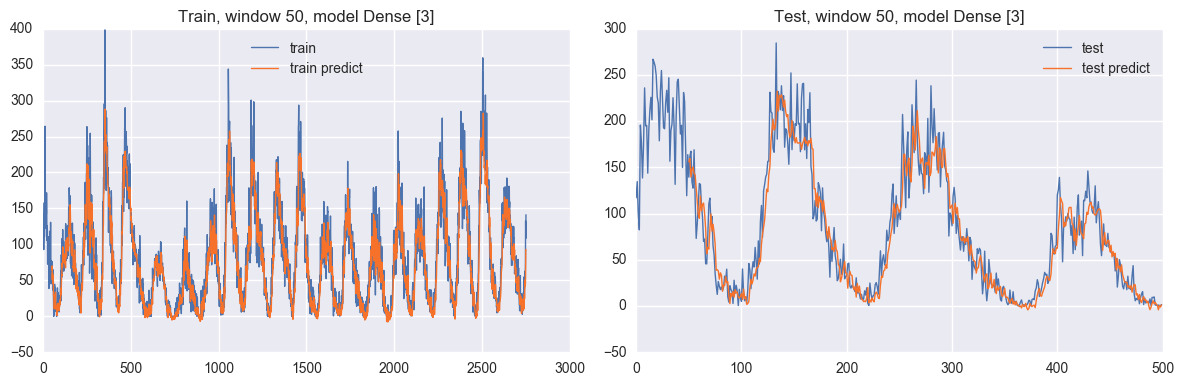

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3)                 60        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Train on 1776 samples, validate on 876 samples
Epoch 1/50
1776/1776 [==============================] - 92s 52ms/step - loss: 0.0772 - acc: 0.0321 - val_loss: 0.0344 - val_acc: 0.0034
Epoch 2/50
1776/1776 [==============================] - 91s 51ms/step - loss: 0.0239 - acc: 0.0338 - val_loss: 0.0242 - val_acc: 0.0034
Epoch 3/50
1776/1776 [==============================] - 91s 51ms/step - loss: 0.0193 - acc: 0.0338 - val_loss: 0.0198 - val_acc: 0.0034
Epoch 4/50
1776/1776 [==============================] - 91s 51ms/step - loss: 0.0172 - 

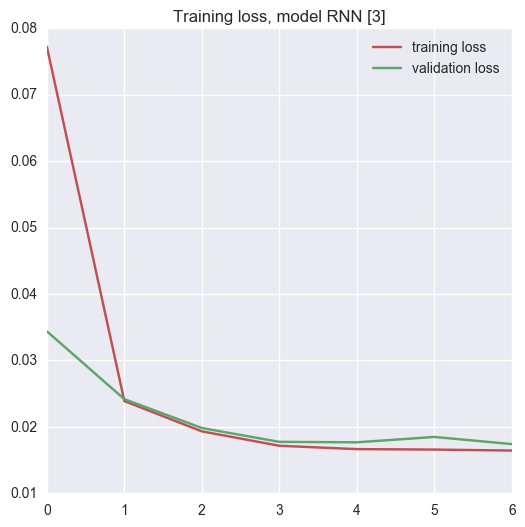

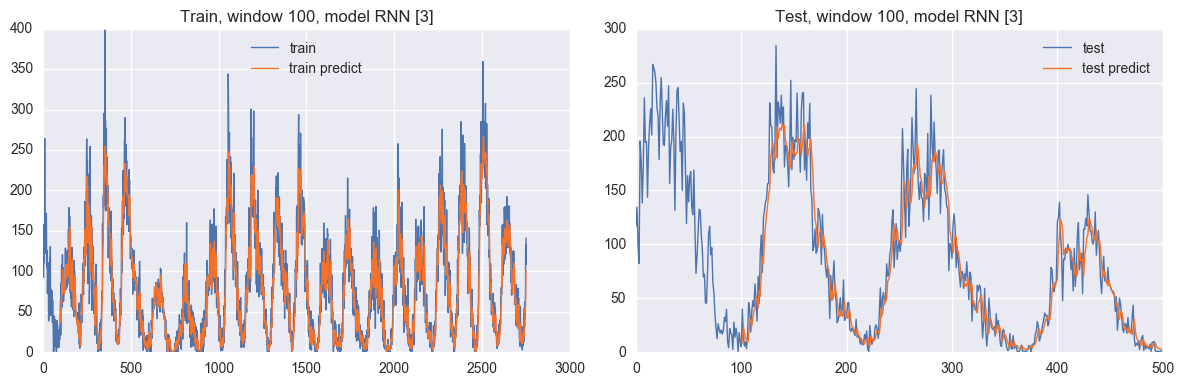

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 3)                 303       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 4         
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________
Train on 1776 samples, validate on 876 samples
Epoch 1/50
1776/1776 [==============================] - 2s 1ms/step - loss: 0.0607 - acc: 0.0332 - mean_absolute_error: 0.1892 - mean_squared_error: 0.0607 - val_loss: 0.0428 - val_acc: 0.0034 - val_mean_absolute_error: 0.1626 - val_mean_squared_error: 0.0428
Epoch 2/50
1776/1776 [==============================] - 1s 737us/step - loss: 0.0315 - acc: 0.0338 - 

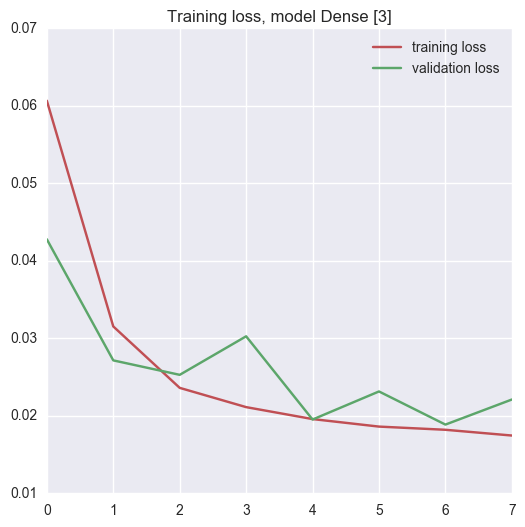

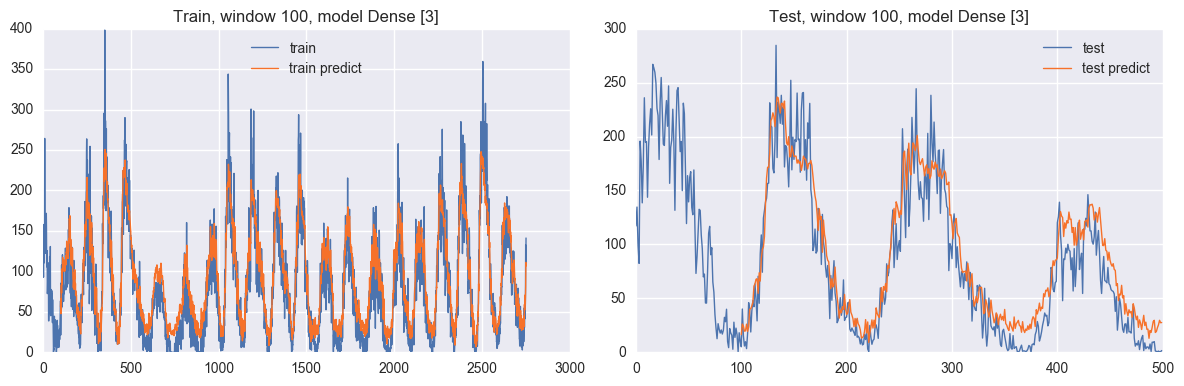

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3)                 60        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Train on 1709 samples, validate on 843 samples
Epoch 1/50
1709/1709 [==============================] - 172s 101ms/step - loss: 0.0817 - acc: 0.0322 - val_loss: 0.0333 - val_acc: 0.0036
Epoch 2/50
1709/1709 [==============================] - 172s 101ms/step - loss: 0.0243 - acc: 0.0351 - val_loss: 0.0237 - val_acc: 0.0036
Epoch 3/50
1709/1709 [==============================] - 171s 100ms/step - loss: 0.0199 - acc: 0.0351 - val_loss: 0.0193 - val_acc: 0.0036
Epoch 4/50
1709/1709 [==============================] - 171s 100ms/step - loss: 0

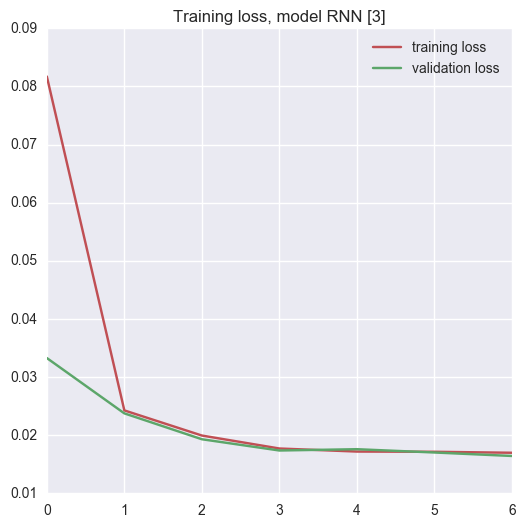

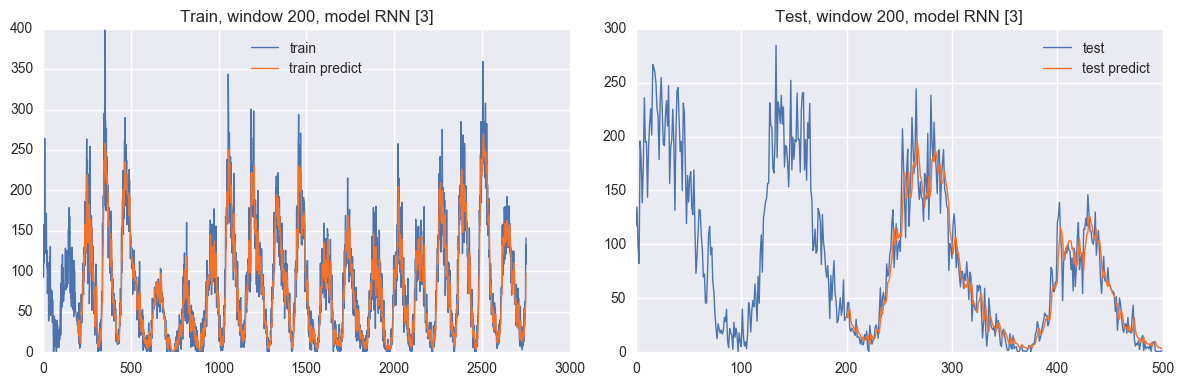

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 3)                 603       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 4         
Total params: 607
Trainable params: 607
Non-trainable params: 0
_________________________________________________________________
Train on 1709 samples, validate on 843 samples
Epoch 1/50
1709/1709 [==============================] - 2s 1ms/step - loss: 0.0899 - acc: 0.0328 - mean_absolute_error: 0.2258 - mean_squared_error: 0.0899 - val_loss: 0.0427 - val_acc: 0.0036 - val_mean_absolute_error: 0.1644 - val_mean_squared_error: 0.0427
Epoch 2/50
1709/1709 [==============================] - 1s 776us/step - loss: 0.0371 - acc: 0.0351 - 

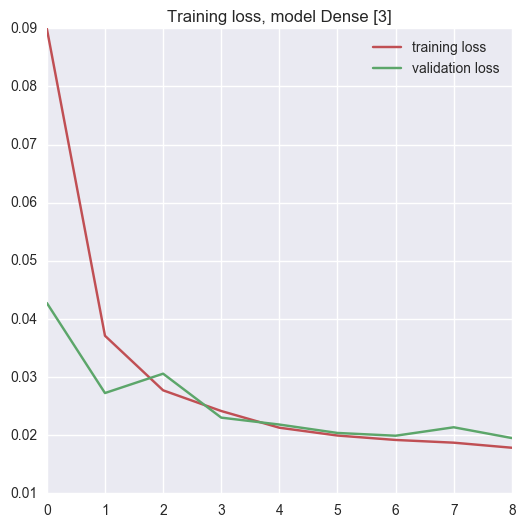

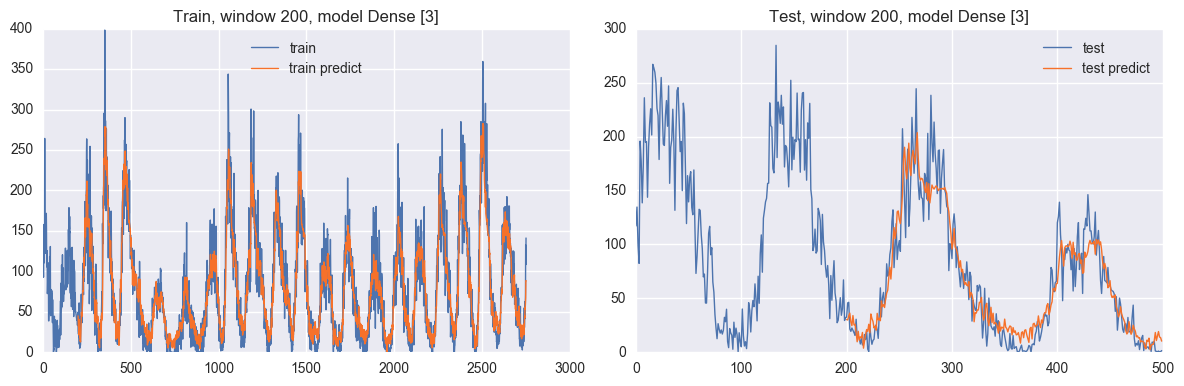

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 3)              60        
_________________________________________________________________
lstm_6 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
Train on 1840 samples, validate on 907 samples
Epoch 1/50
1840/1840 [==============================] - 14s 8ms/step - loss: 0.0578 - acc: 0.0321 - val_loss: 0.0263 - val_acc: 0.0033
Epoch 2/50
1840/1840 [==============================] - 12s 7ms/step - loss: 0.0213 - acc: 0.0342 - val_loss: 0.0242 - val_acc: 0.0033
Epoch 3/50
1840/1840 [==============================] - 12s 7ms/step - loss: 0.0204 - acc: 

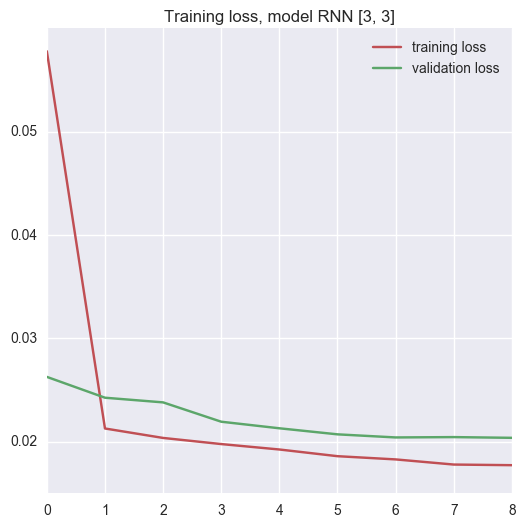

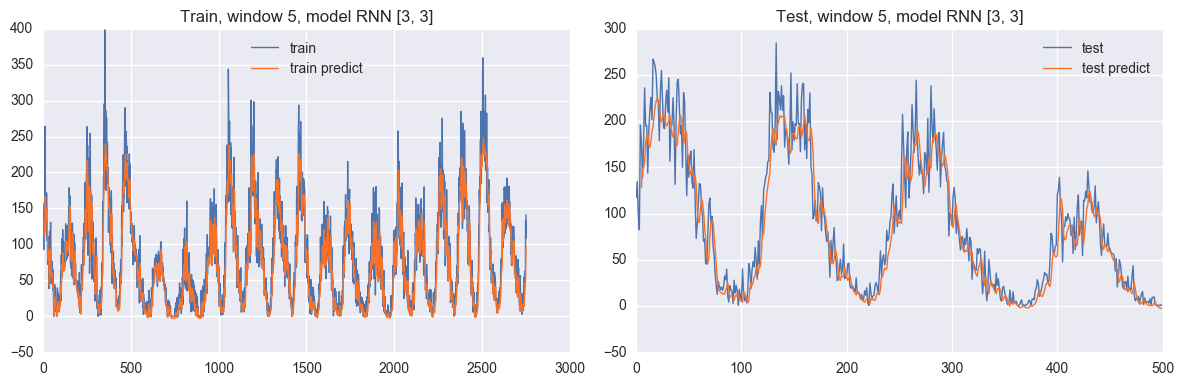

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 3)                 18        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 4         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________
Train on 1840 samples, validate on 907 samples
Epoch 1/50
1840/1840 [==============================] - 3s 1ms/step - loss: 0.0859 - acc: 0.0299 - 

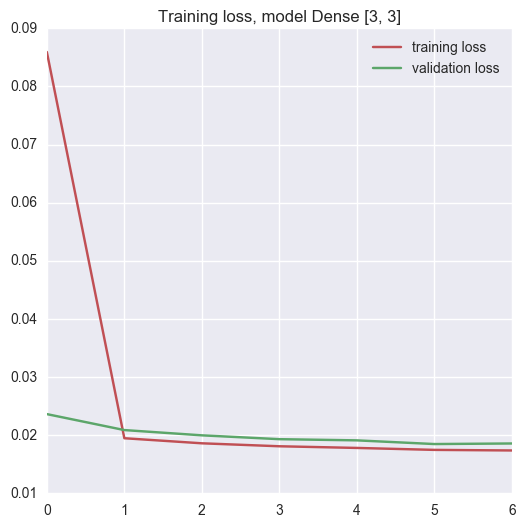

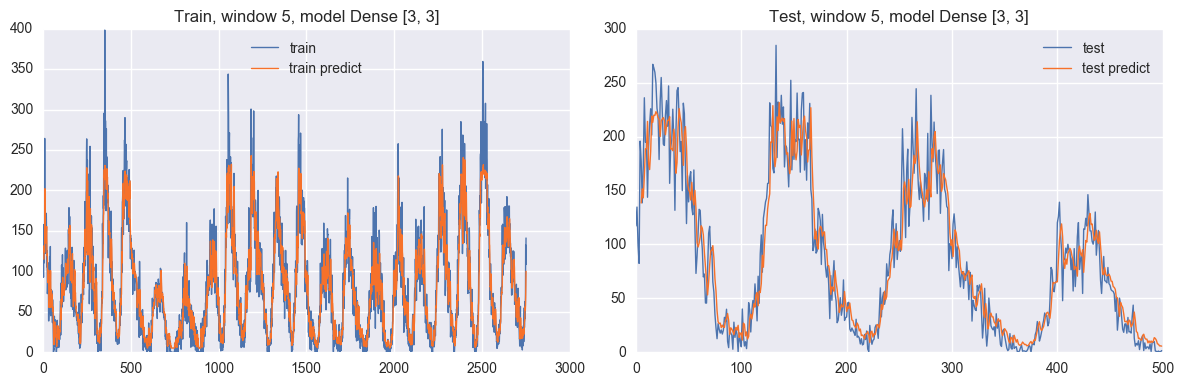

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 3)             60        
_________________________________________________________________
lstm_8 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
Train on 1810 samples, validate on 892 samples
Epoch 1/50
1810/1810 [==============================] - 97s 53ms/step - loss: 0.0465 - acc: 0.0320 - val_loss: 0.0244 - val_acc: 0.0034
Epoch 2/50
1810/1810 [==============================] - 97s 54ms/step - loss: 0.0199 - acc: 0.0348 - val_loss: 0.0233 - val_acc: 0.0034
Epoch 3/50
1810/1810 [==============================] - 98s 54ms/step - loss: 0.0189 - ac

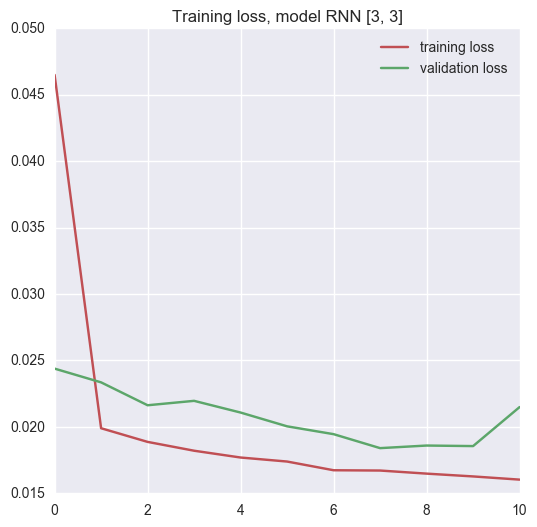

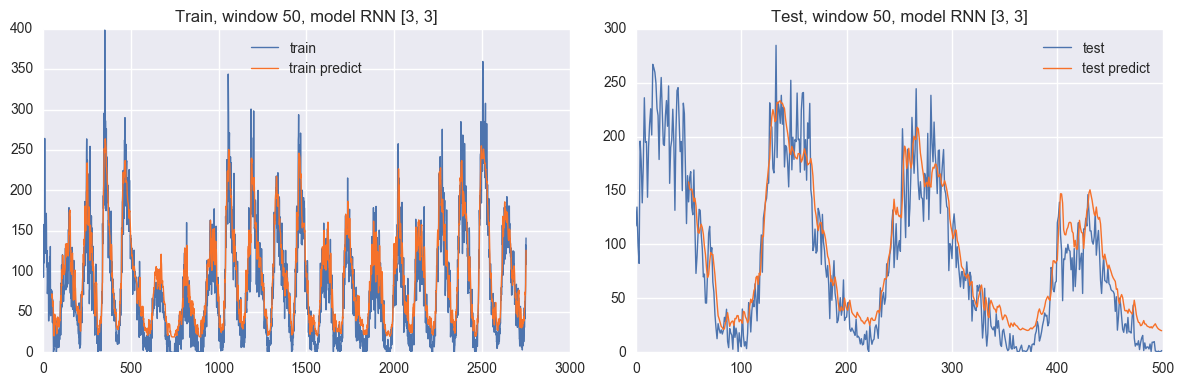

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 3)                 153       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 4         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
Train on 1810 samples, validate on 892 samples
Epoch 1/50
1810/1810 [==============================] - 3s 2ms/step - loss: 0.0404 - acc: 0.0343 

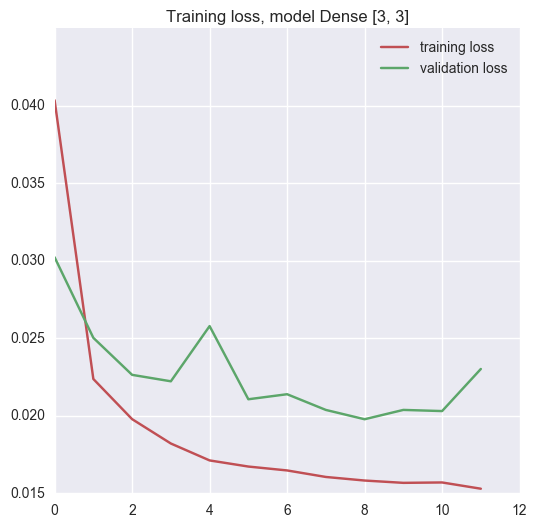

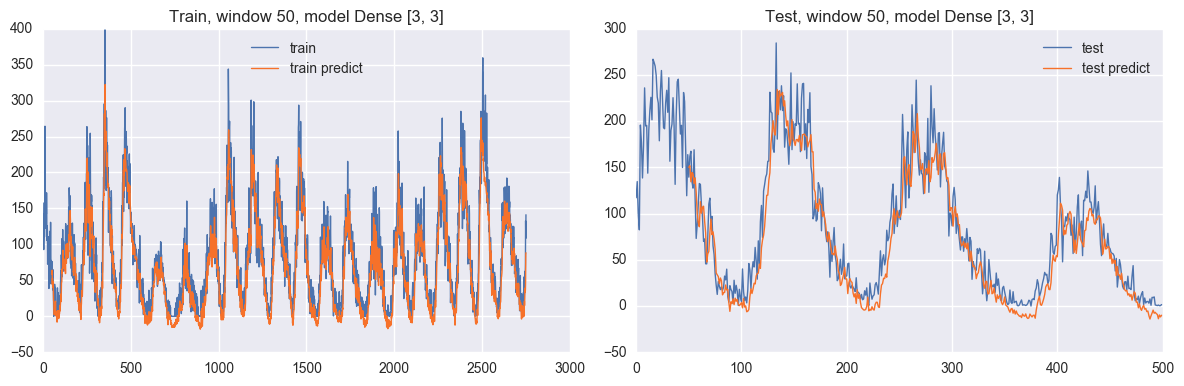

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 3)            60        
_________________________________________________________________
lstm_10 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
Train on 1776 samples, validate on 876 samples
Epoch 1/50
1776/1776 [==============================] - 170s 95ms/step - loss: 0.0470 - acc: 0.0315 - val_loss: 0.0254 - val_acc: 0.0034
Epoch 2/50
1776/1776 [==============================] - 167s 94ms/step - loss: 0.0205 - acc: 0.0338 - val_loss: 0.0252 - val_acc: 0.0034
Epoch 3/50
1776/1776 [==============================] - 167s 94ms/step - loss: 0.0193 -

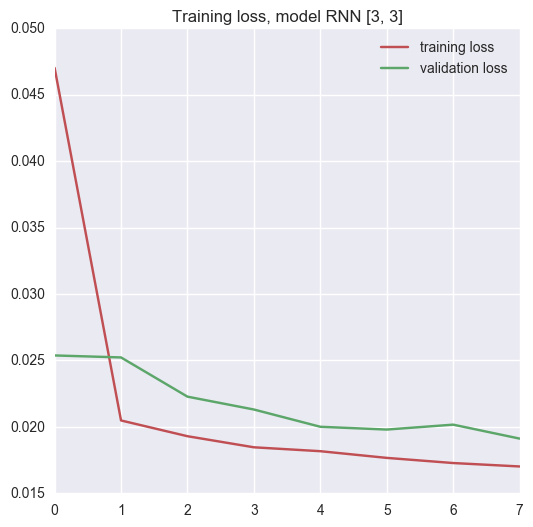

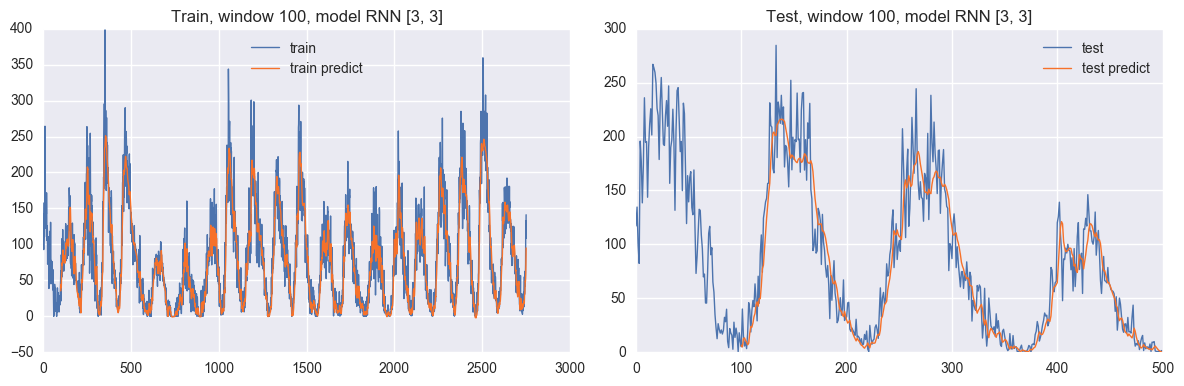

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 3)                 303       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 4         
Total params: 319
Trainable params: 319
Non-trainable params: 0
_________________________________________________________________
Train on 1776 samples, validate on 876 samples
Epoch 1/50
1776/1776 [==============================] - 3s 2ms/step - loss: 0.0421 - acc: 0.0332 

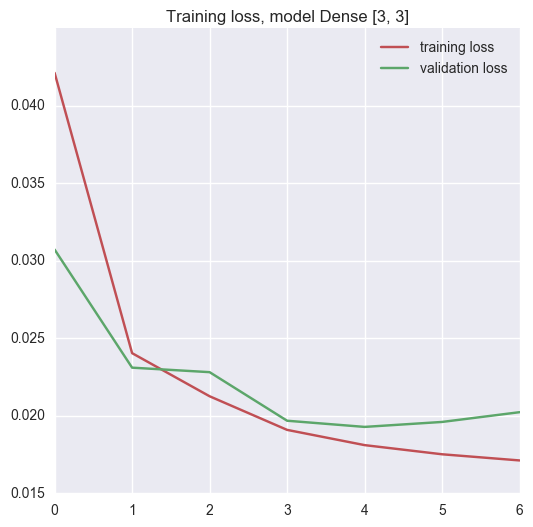

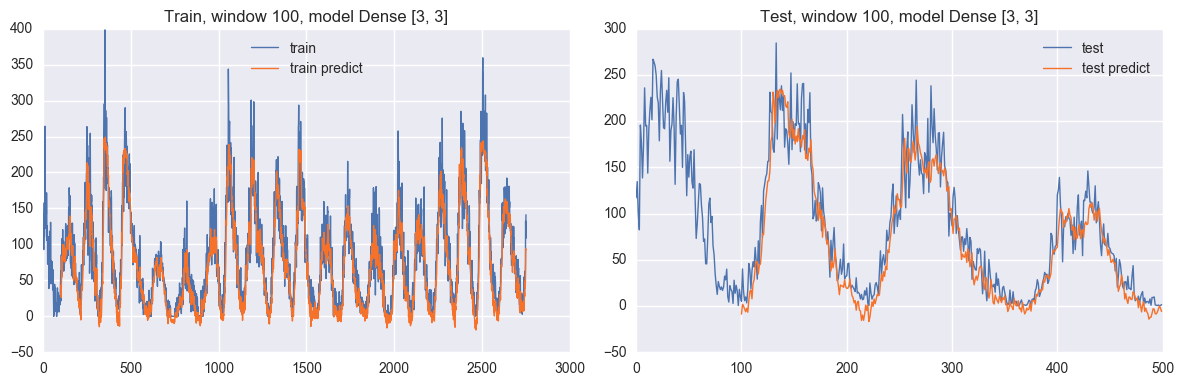

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 200, 3)            60        
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
Train on 1709 samples, validate on 843 samples
Epoch 1/50
1709/1709 [==============================] - 324s 190ms/step - loss: 0.0518 - acc: 0.0328 - val_loss: 0.0276 - val_acc: 0.0036
Epoch 2/50
1709/1709 [==============================] - 324s 189ms/step - loss: 0.0207 - acc: 0.0351 - val_loss: 0.0227 - val_acc: 0.0036
Epoch 3/50
1709/1709 [==============================] - 336s 196ms/step - loss: 0.019

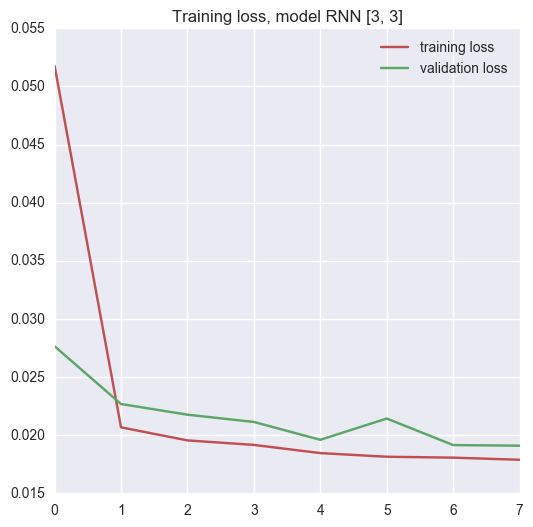

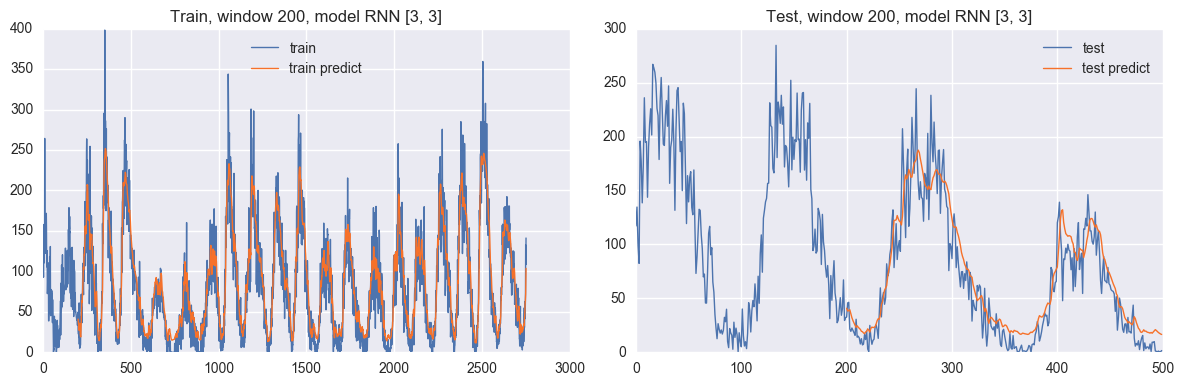

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 3)                 603       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 4         
Total params: 619
Trainable params: 619
Non-trainable params: 0
_________________________________________________________________
Train on 1709 samples, validate on 843 samples
Epoch 1/50
1709/1709 [==============================] - 3s 2ms/step - loss: 0.0560 - acc: 0.0345 

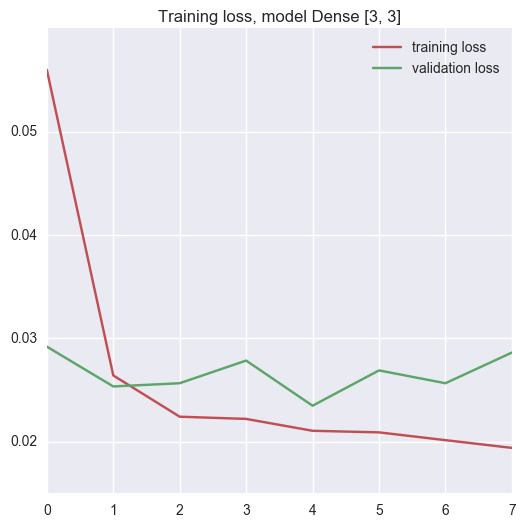

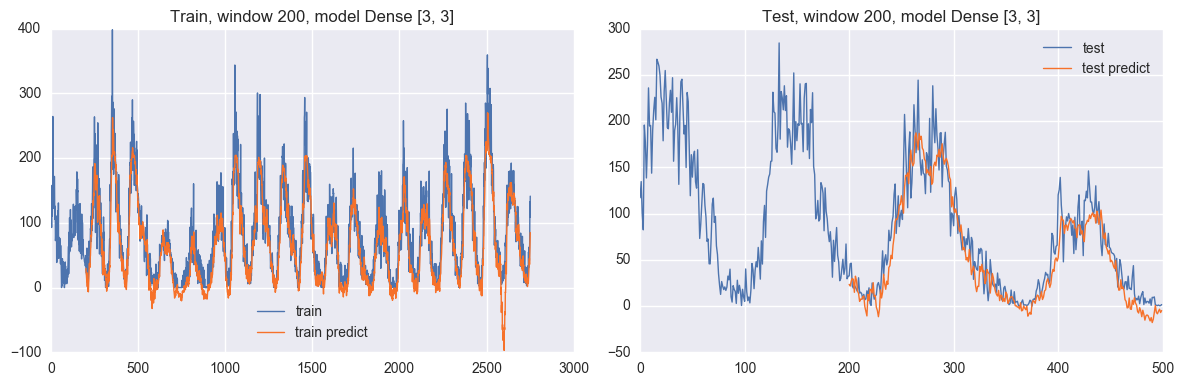

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 5, 3)              60        
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 3)              84        
_________________________________________________________________
lstm_15 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 4         
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________
Train on 1840 samples, validate on 907 samples
Epoch 1/50
1840/1840 [==============================] - 23s 13ms/step - loss: 0.0424 - acc: 0.0315 - val_loss: 0.0277 - val_acc: 0.0033
Epoch 2/50
1840/1840 [==============================] - 20s 11ms/step - loss: 0.0228 - acc: 0

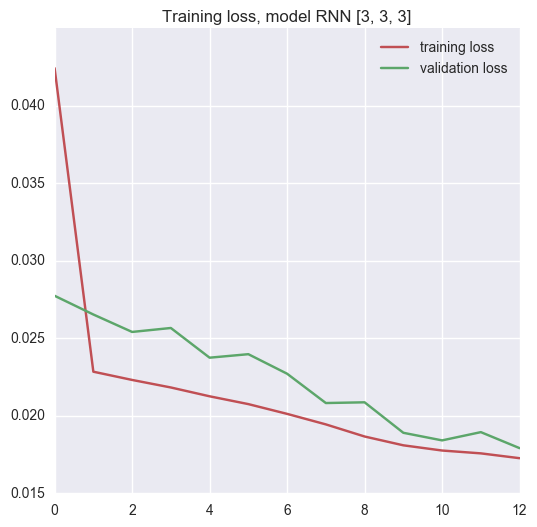

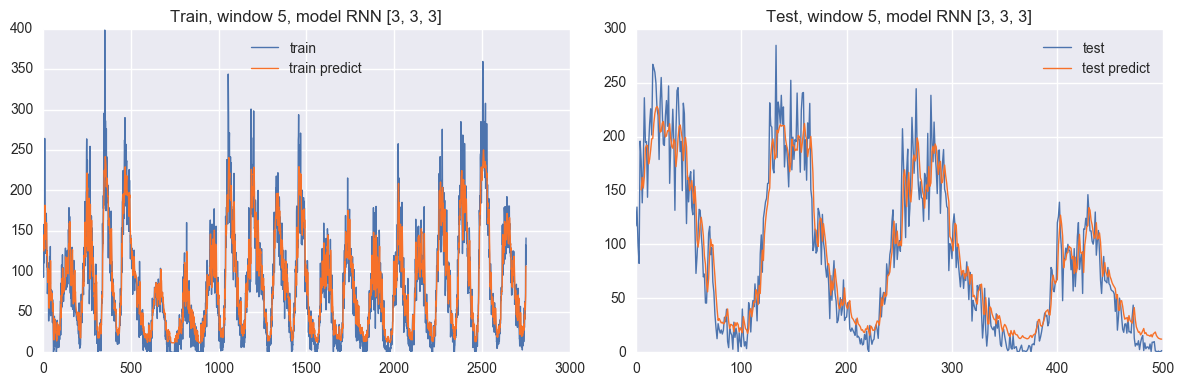

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 3)                 18        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 4         
Total para

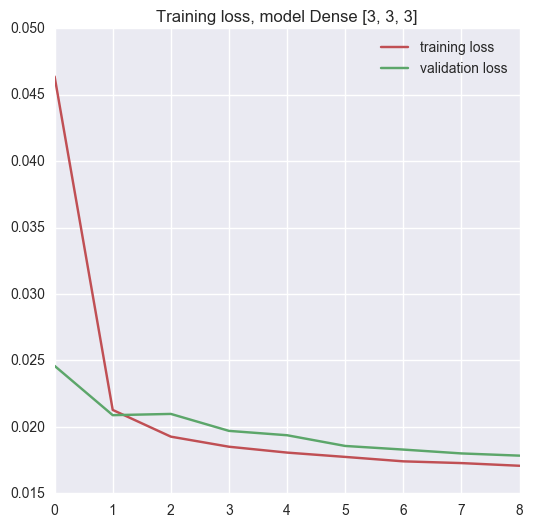

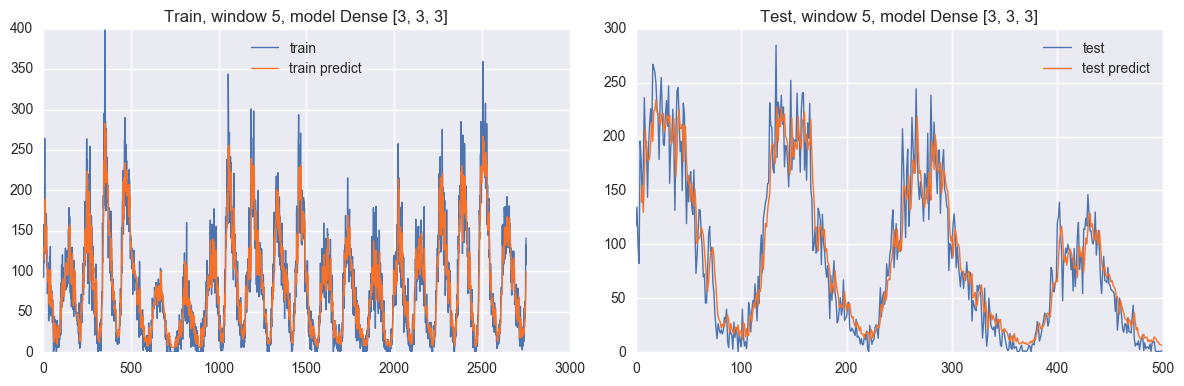

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 50, 3)             60        
_________________________________________________________________
lstm_17 (LSTM)               (None, 50, 3)             84        
_________________________________________________________________
lstm_18 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 4         
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________
Train on 1810 samples, validate on 892 samples
Epoch 1/50
1810/1810 [==============================] - 130s 72ms/step - loss: 0.0390 - acc: 0.0348 - val_loss: 0.0241 - val_acc: 0.0034
Epoch 2/50
1810/1810 [==============================] - 127s 70ms/step - loss: 0.0209 - acc:

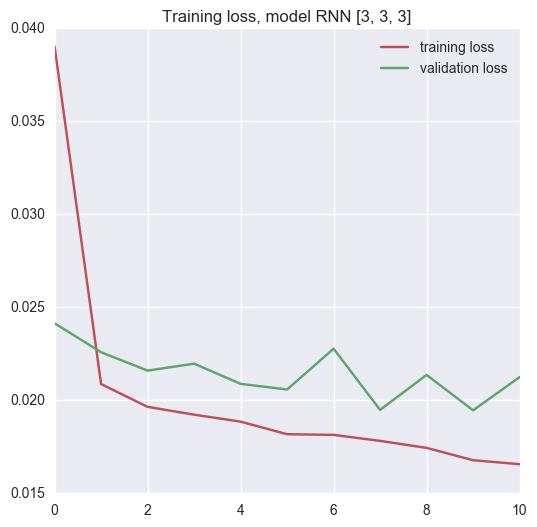

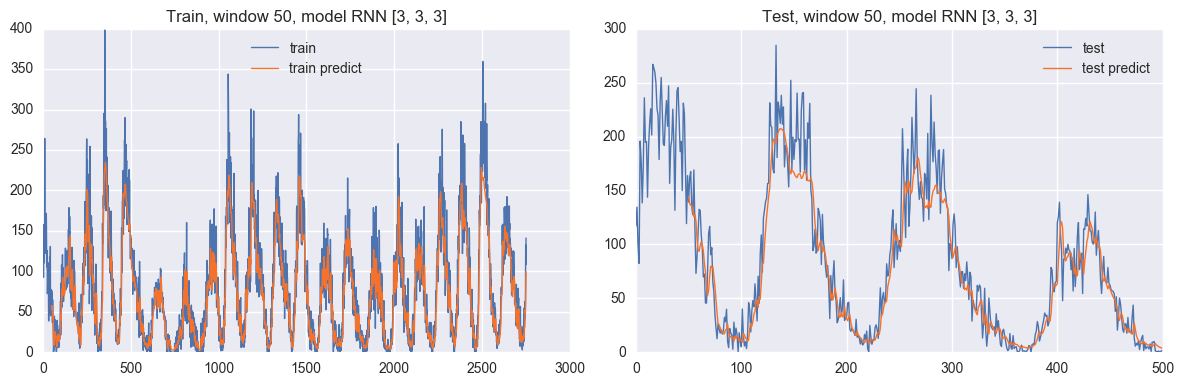

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 3)                 153       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 4         
Total para

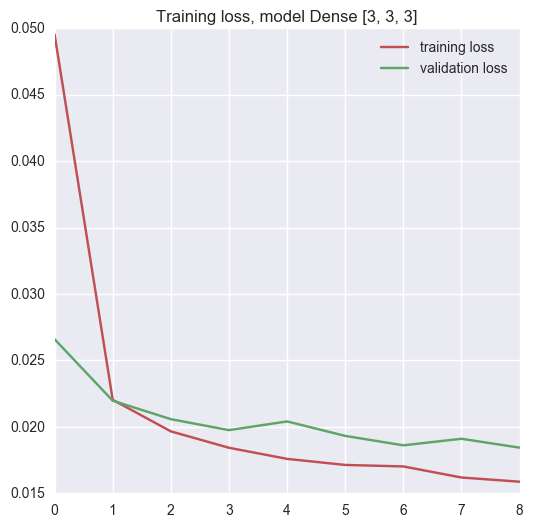

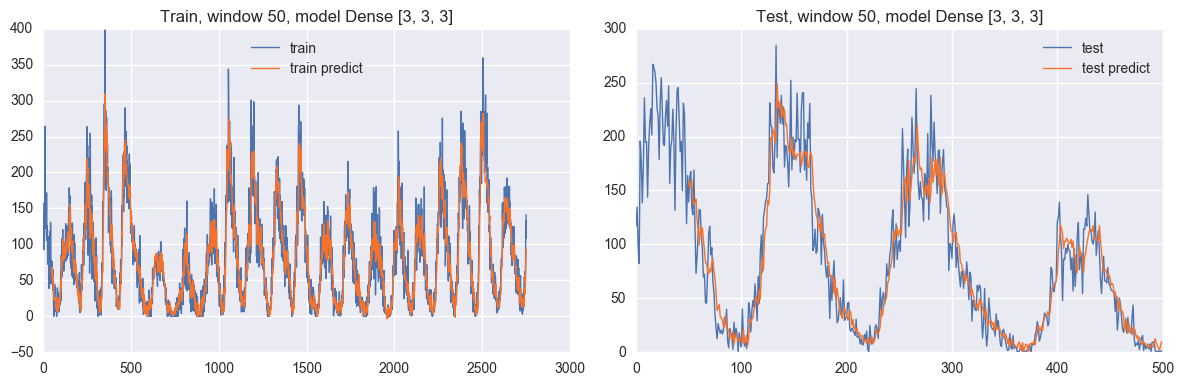

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100, 3)            60        
_________________________________________________________________
lstm_20 (LSTM)               (None, 100, 3)            84        
_________________________________________________________________
lstm_21 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 4         
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________
Train on 1776 samples, validate on 876 samples
Epoch 1/50
1776/1776 [==============================] - 287s 162ms/step - loss: 0.0420 - acc: 0.0327 - val_loss: 0.0271 - val_acc: 0.0034
Epoch 2/50
1776/1776 [==============================] - 285s 160ms/step - loss: 0.0210 - ac

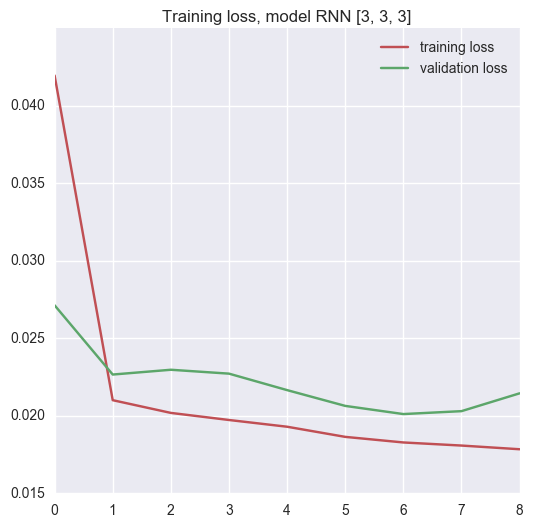

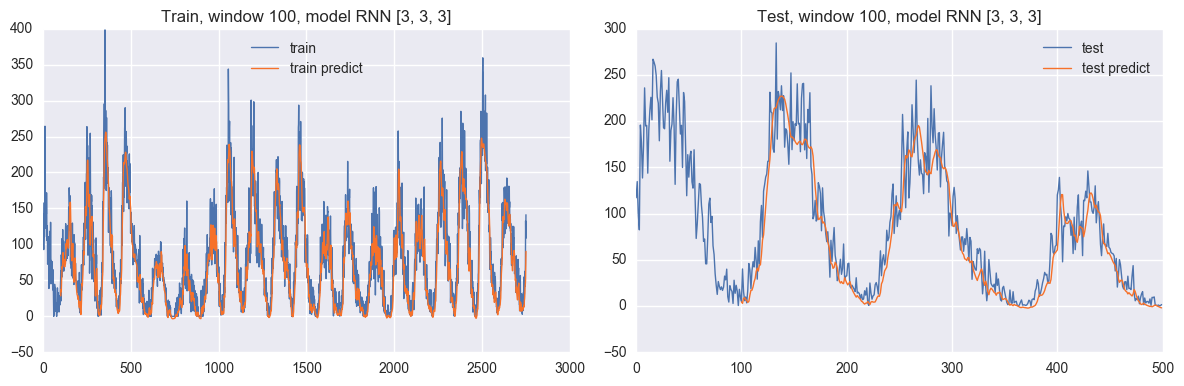

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 3)                 303       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 4         
Total para

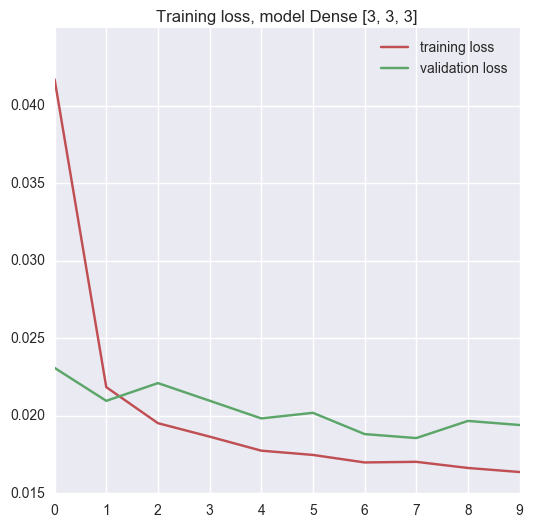

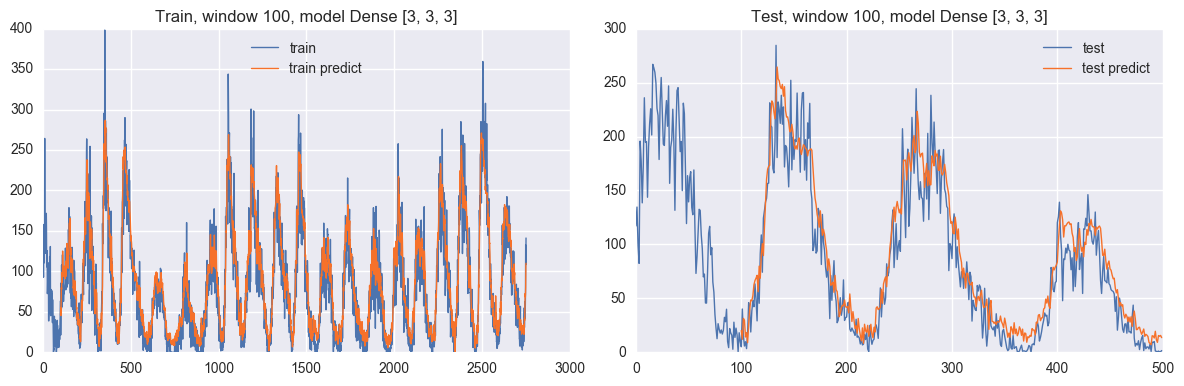

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 200, 3)            60        
_________________________________________________________________
lstm_23 (LSTM)               (None, 200, 3)            84        
_________________________________________________________________
lstm_24 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 4         
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________
Train on 1709 samples, validate on 843 samples
Epoch 1/50
1709/1709 [==============================] - 481s 282ms/step - loss: 0.0417 - acc: 0.0334 - val_loss: 0.0299 - val_acc: 0.0036
Epoch 2/50
1709/1709 [==============================] - 478s 280ms/step - loss: 0.0213 - ac

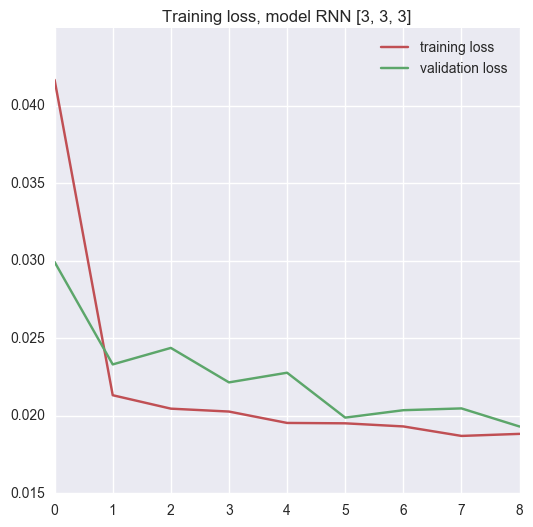

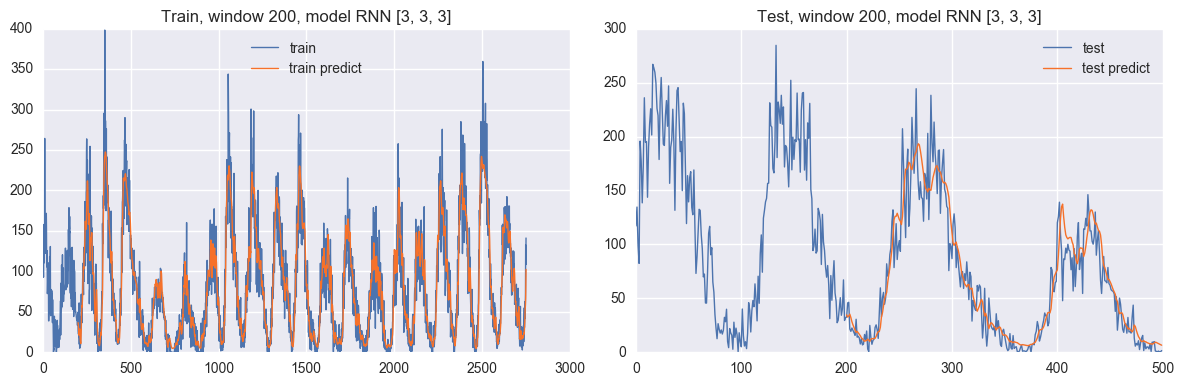

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 3)                 603       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_47 (Dense)             (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 4         
Total para

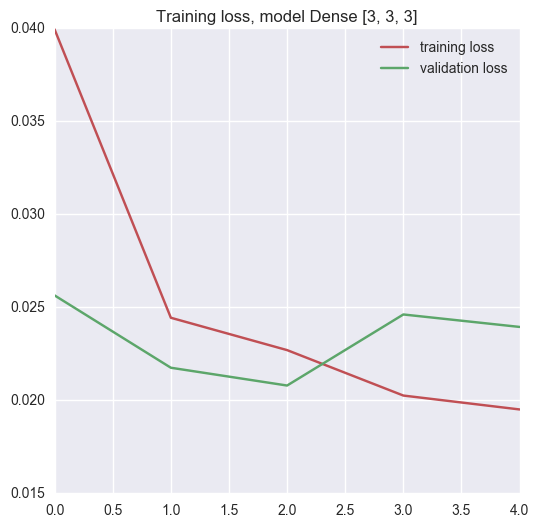

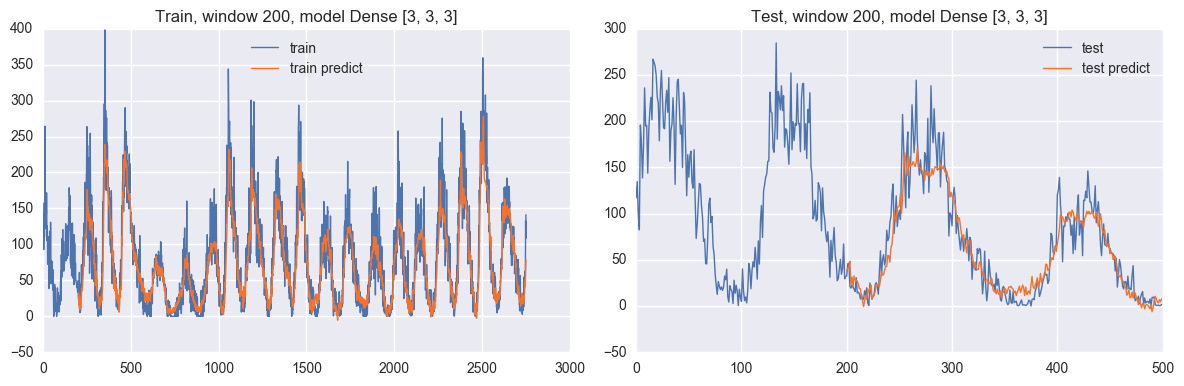

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 5, 4)              96        
_________________________________________________________________
lstm_26 (LSTM)               (None, 5, 2)              56        
_________________________________________________________________
lstm_27 (LSTM)               (None, 1)                 16        
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 2         
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
Train on 1840 samples, validate on 907 samples
Epoch 1/50
1840/1840 [==============================] - 21s 12ms/step - loss: 0.0632 - acc: 0.0304 - val_loss: 0.0304 - val_acc: 0.0033
Epoch 2/50
1840/1840 [==============================] - 17s 9ms/step - loss: 0.0229 - acc: 0.

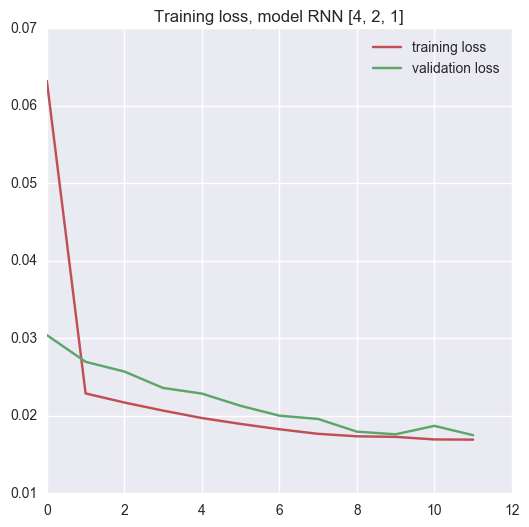

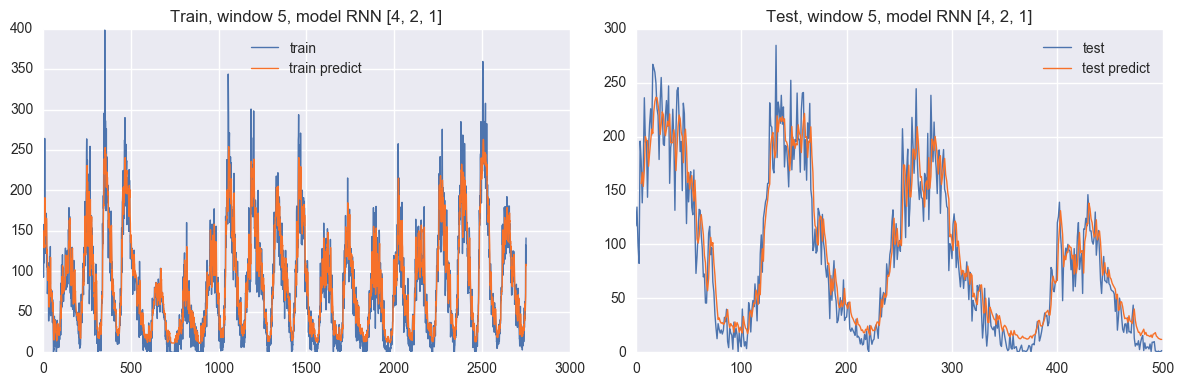

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 4)                 24        
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 4)                 0         
_________________________________________________________________
dense_51 (Dense)             (None, 2)                 10        
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 2)                 0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 3         
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 1)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 2         
Total para

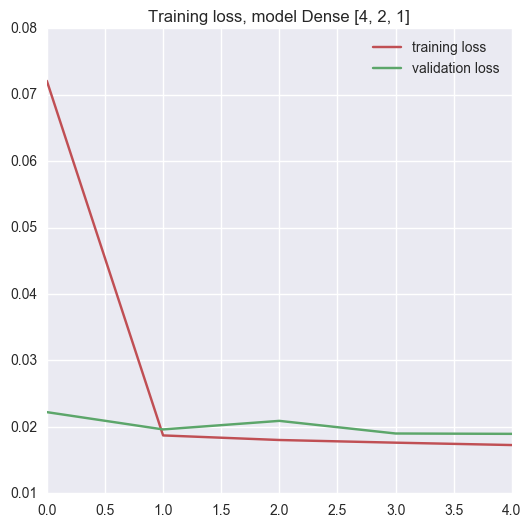

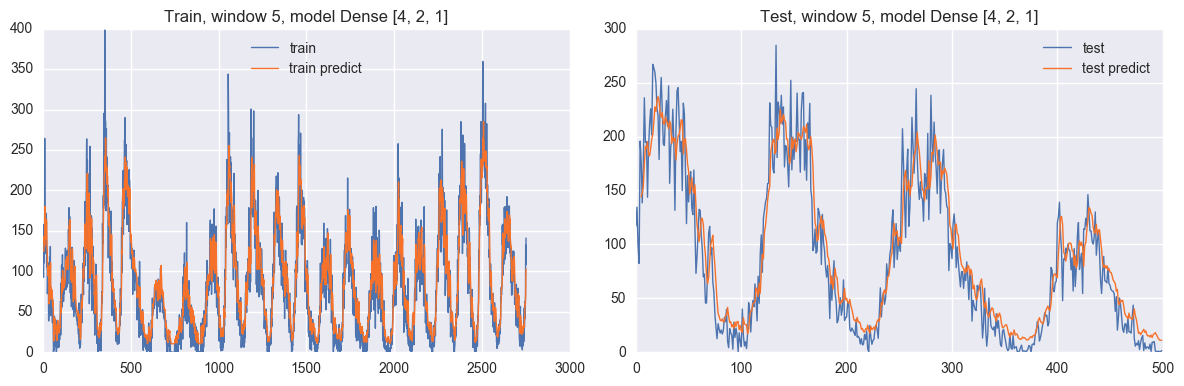

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 50, 4)             96        
_________________________________________________________________
lstm_29 (LSTM)               (None, 50, 2)             56        
_________________________________________________________________
lstm_30 (LSTM)               (None, 1)                 16        
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 2         
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
Train on 1810 samples, validate on 892 samples
Epoch 1/50
1810/1810 [==============================] - 129s 72ms/step - loss: 0.0611 - acc: 0.0326 - val_loss: 0.0330 - val_acc: 0.0034
Epoch 2/50
1810/1810 [==============================] - 133s 73ms/step - loss: 0.0228 - acc:

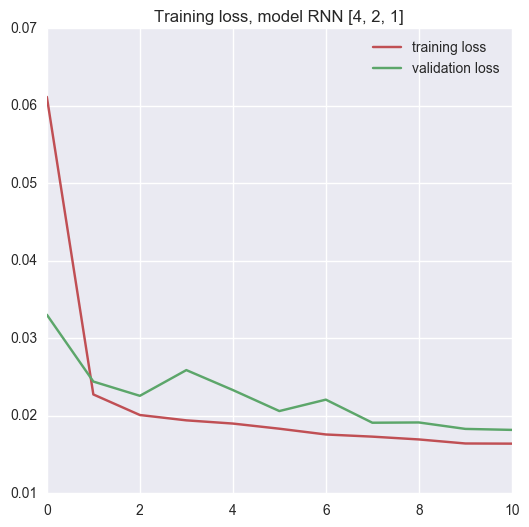

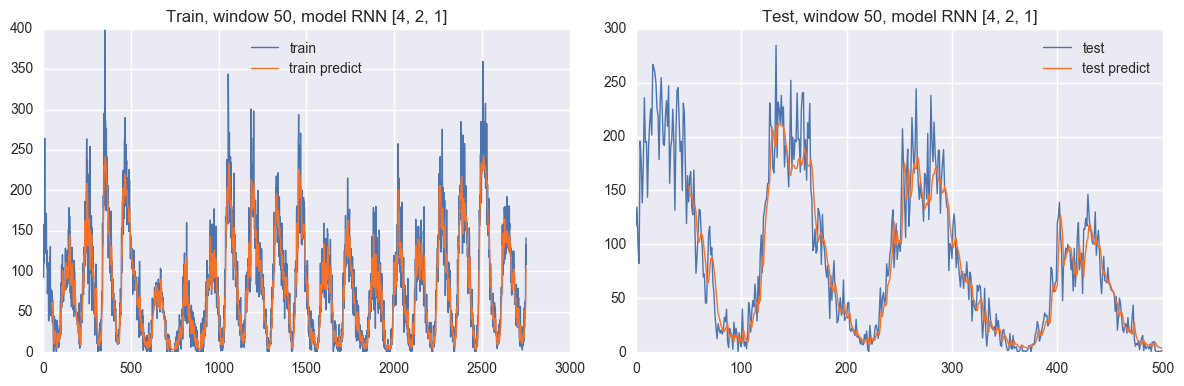

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 4)                 204       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 4)                 0         
_________________________________________________________________
dense_56 (Dense)             (None, 2)                 10        
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 2)                 0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 3         
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 1)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 2         
Total para

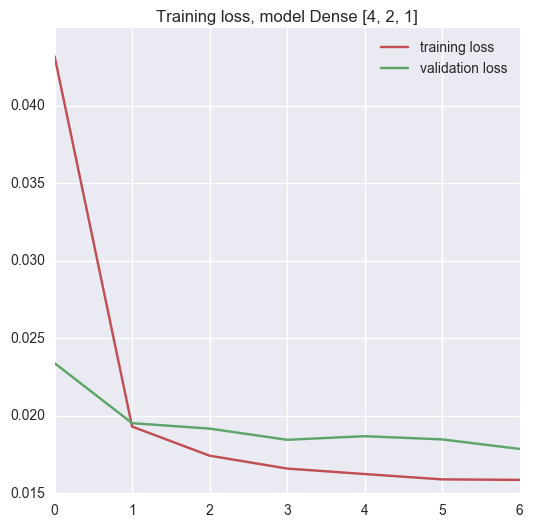

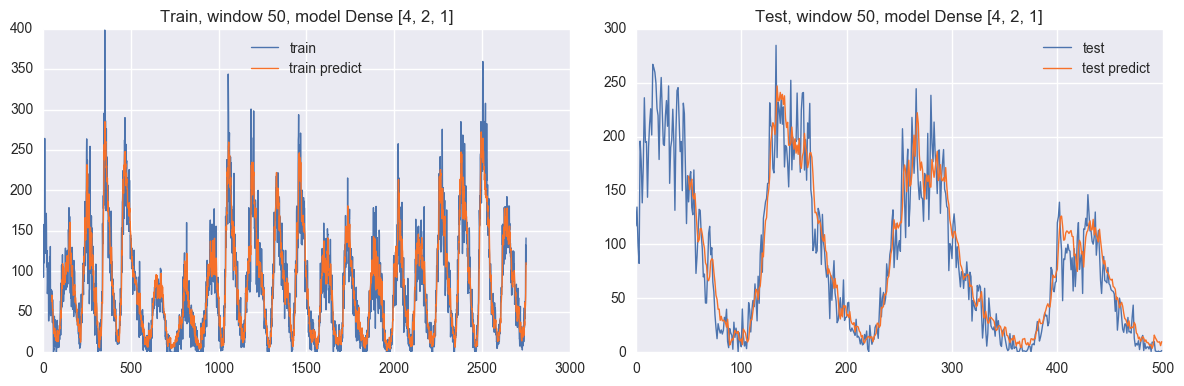

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 100, 4)            96        
_________________________________________________________________
lstm_32 (LSTM)               (None, 100, 2)            56        
_________________________________________________________________
lstm_33 (LSTM)               (None, 1)                 16        
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 2         
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
Train on 1776 samples, validate on 876 samples
Epoch 1/50
1776/1776 [==============================] - 295s 166ms/step - loss: 0.0633 - acc: 0.0293 - val_loss: 0.0358 - val_acc: 0.0034
Epoch 2/50
1776/1776 [==============================] - 276s 156ms/step - loss: 0.0241 - ac

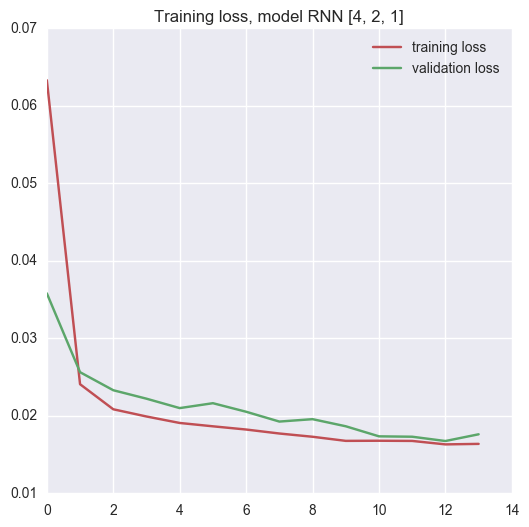

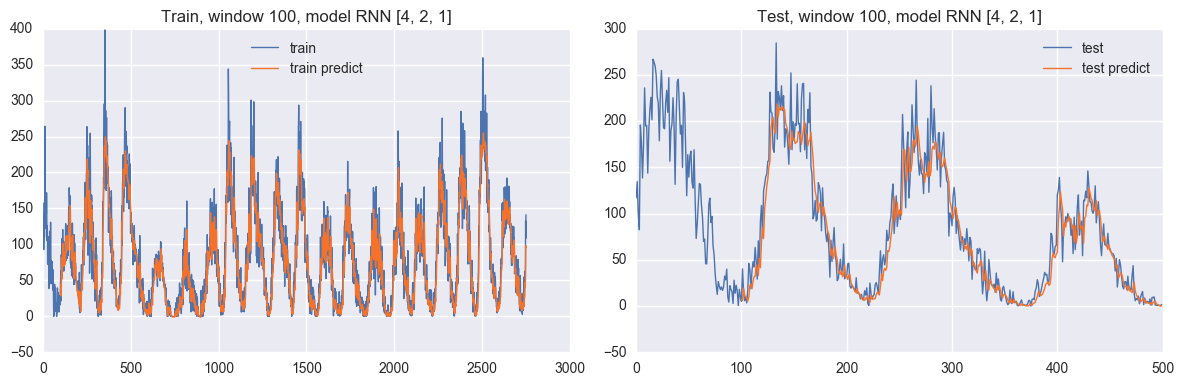

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 4)                 404       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 4)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 2)                 10        
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 2)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 3         
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 1)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 2         
Total para

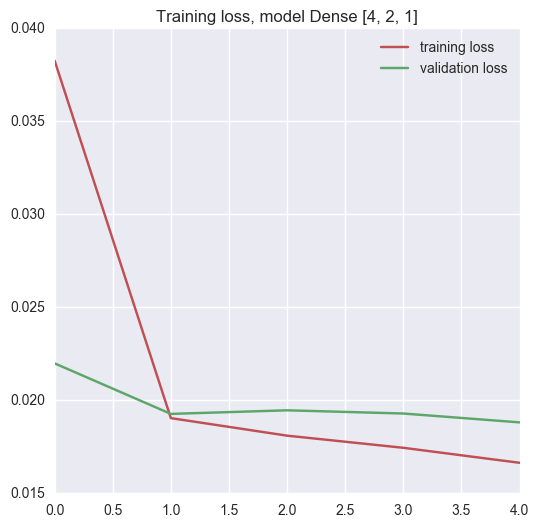

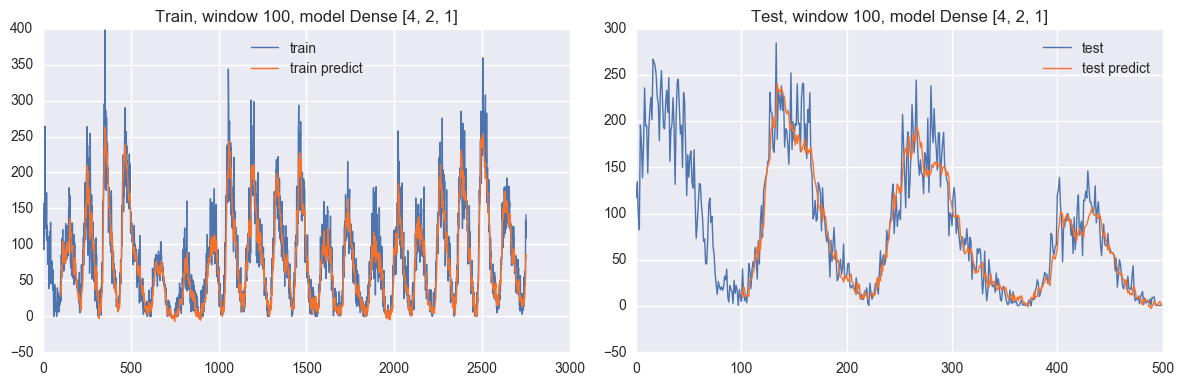

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 200, 4)            96        
_________________________________________________________________
lstm_35 (LSTM)               (None, 200, 2)            56        
_________________________________________________________________
lstm_36 (LSTM)               (None, 1)                 16        
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 2         
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
Train on 1709 samples, validate on 843 samples
Epoch 1/50
1709/1709 [==============================] - 524s 306ms/step - loss: 0.0654 - acc: 0.0328 - val_loss: 0.0357 - val_acc: 0.0036
Epoch 2/50
1709/1709 [==============================] - 521s 305ms/step - loss: 0.0245 - ac

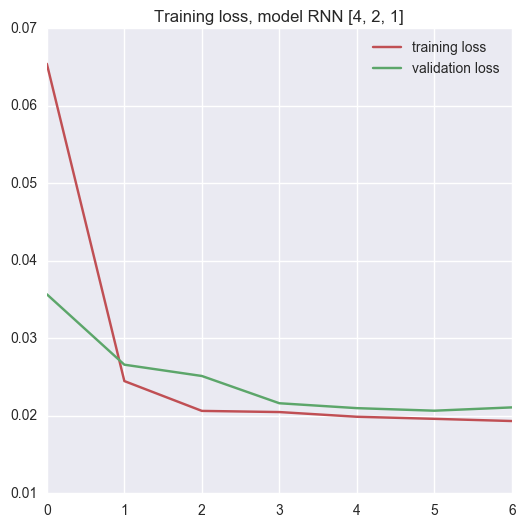

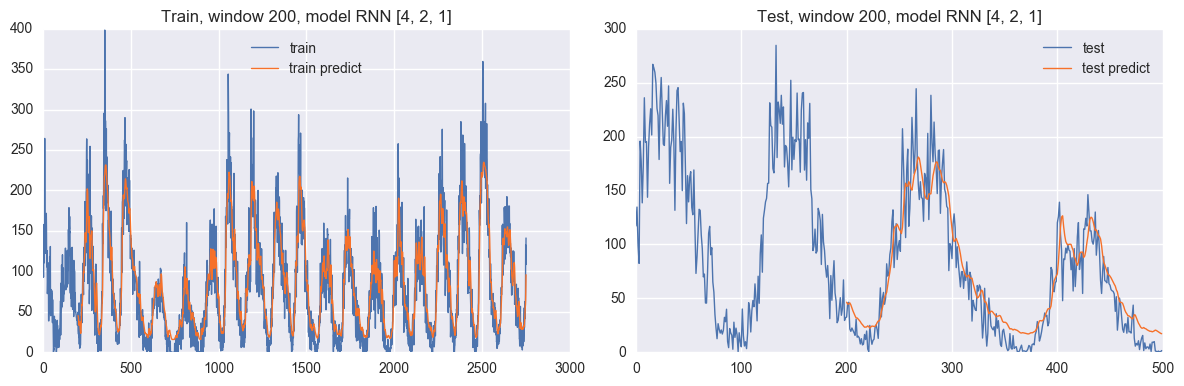

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 4)                 804       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 4)                 0         
_________________________________________________________________
dense_66 (Dense)             (None, 2)                 10        
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 2)                 0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 3         
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 1)                 0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 2         
Total para

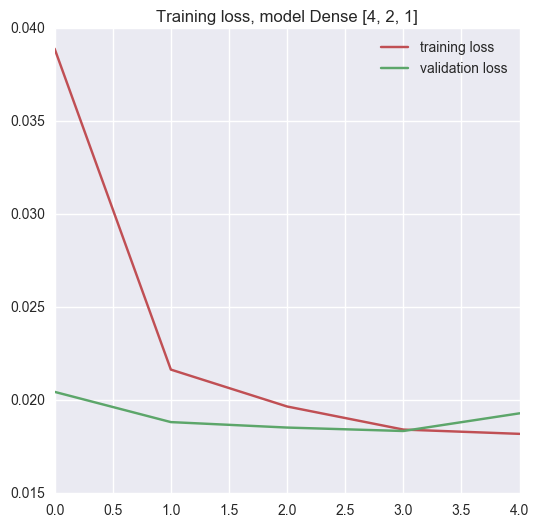

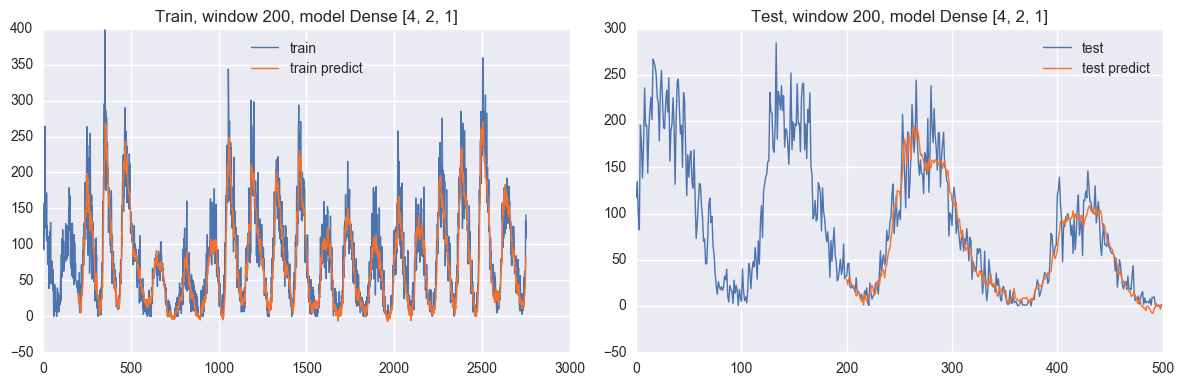

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 5, 256)            264192    
_________________________________________________________________
lstm_38 (LSTM)               (None, 5, 128)            197120    
_________________________________________________________________
lstm_39 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 33        
Total params: 481,953
Trainable params: 481,953
Non-trainable params: 0
_________________________________________________________________
Train on 1840 samples, validate on 907 samples
Epoch 1/50
1840/1840 [==============================] - 33s 18ms/step - loss: 0.0261 - acc: 0.0337 - val_loss: 0.0181 - val_acc: 0.0033
Epoch 2/50
1840/1840 [==============================] - 27s 15ms/step - loss: 0.0199 

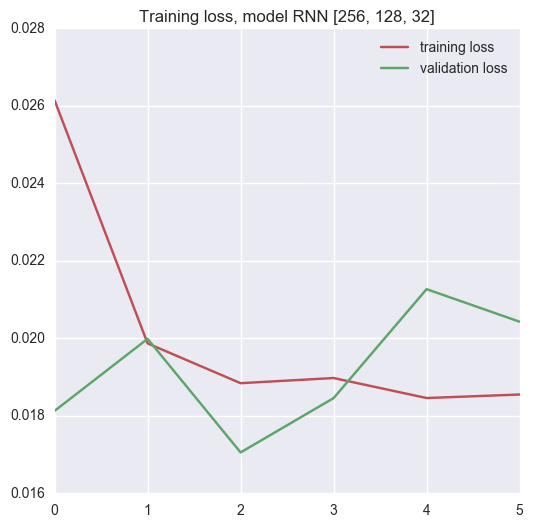

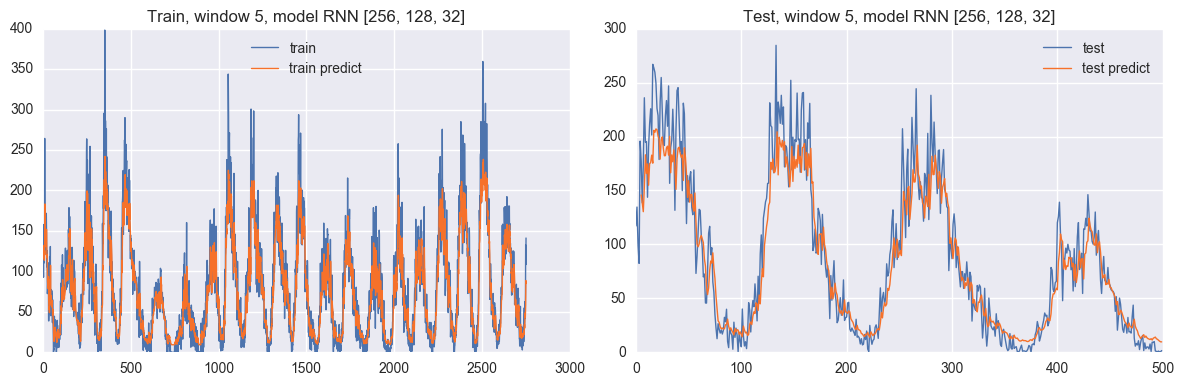

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 256)               1536      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 32)                4128      
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 33        
Total para

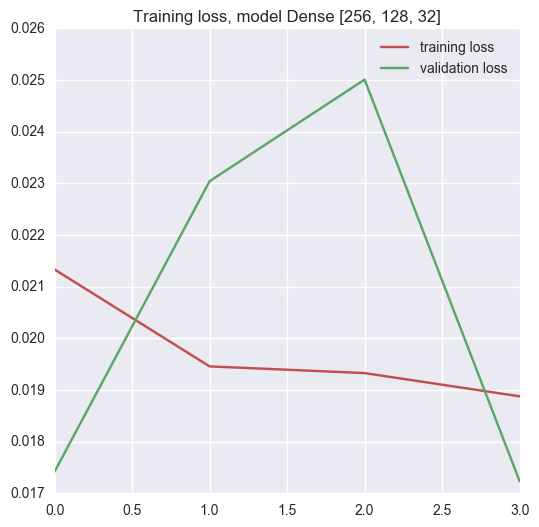

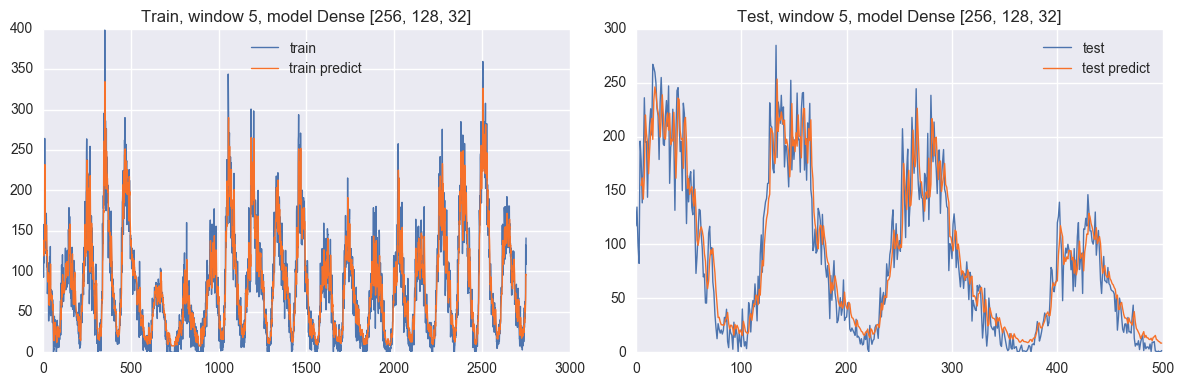

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 50, 256)           264192    
_________________________________________________________________
lstm_41 (LSTM)               (None, 50, 128)           197120    
_________________________________________________________________
lstm_42 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 33        
Total params: 481,953
Trainable params: 481,953
Non-trainable params: 0
_________________________________________________________________
Train on 1810 samples, validate on 892 samples
Epoch 1/50
1810/1810 [==============================] - 141s 78ms/step - loss: 0.0250 - acc: 0.0348 - val_loss: 0.0194 - val_acc: 0.0034
Epoch 2/50
1810/1810 [==============================] - 135s 75ms/step - loss: 0.018

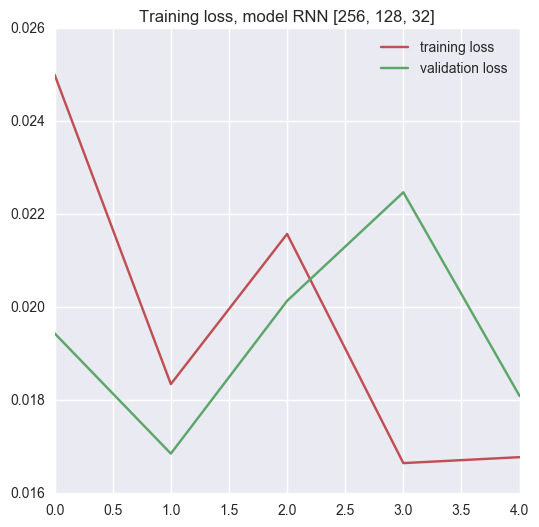

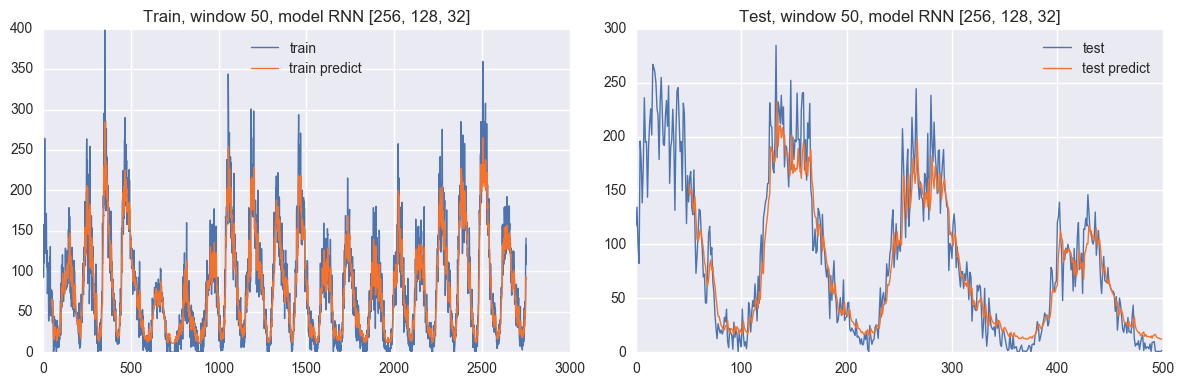

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 256)               13056     
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 32)                4128      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 33        
Total para

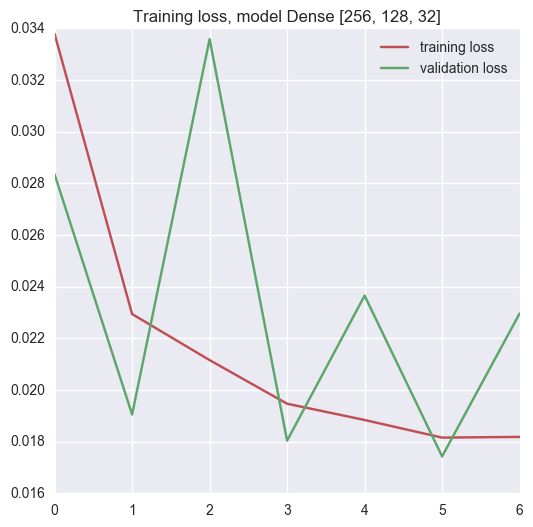

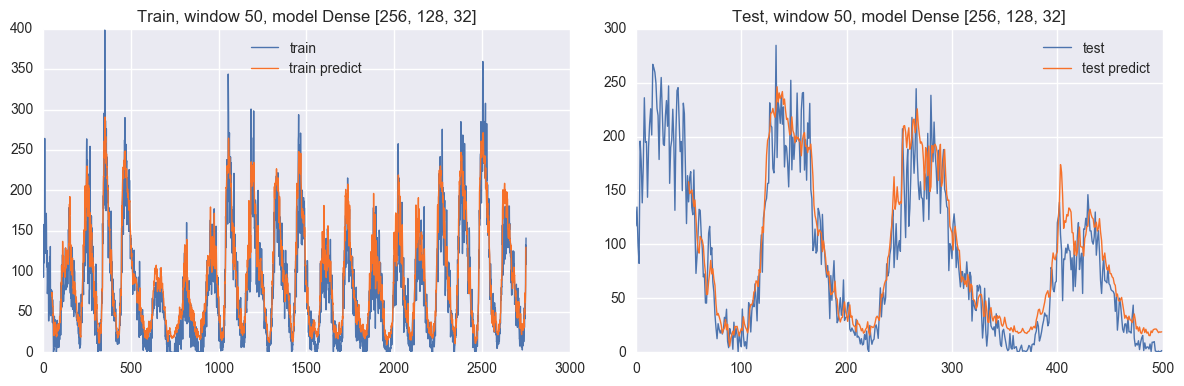

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 100, 256)          264192    
_________________________________________________________________
lstm_44 (LSTM)               (None, 100, 128)          197120    
_________________________________________________________________
lstm_45 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 33        
Total params: 481,953
Trainable params: 481,953
Non-trainable params: 0
_________________________________________________________________
Train on 1776 samples, validate on 876 samples
Epoch 1/50
1776/1776 [==============================] - 262s 147ms/step - loss: 0.0260 - acc: 0.0338 - val_loss: 0.0196 - val_acc: 0.0034
Epoch 2/50
1776/1776 [==============================] - 257s 145ms/step - loss: 0.0

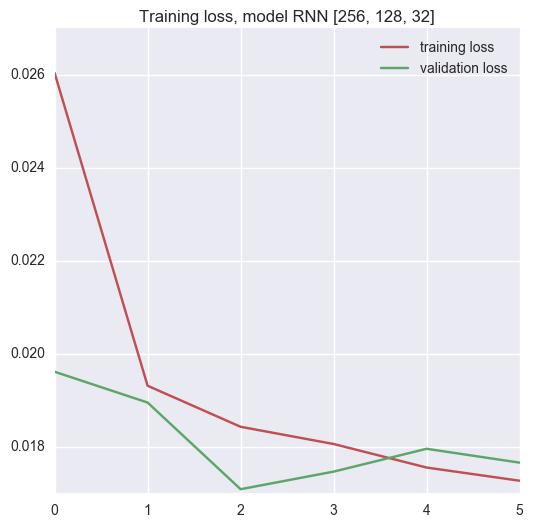

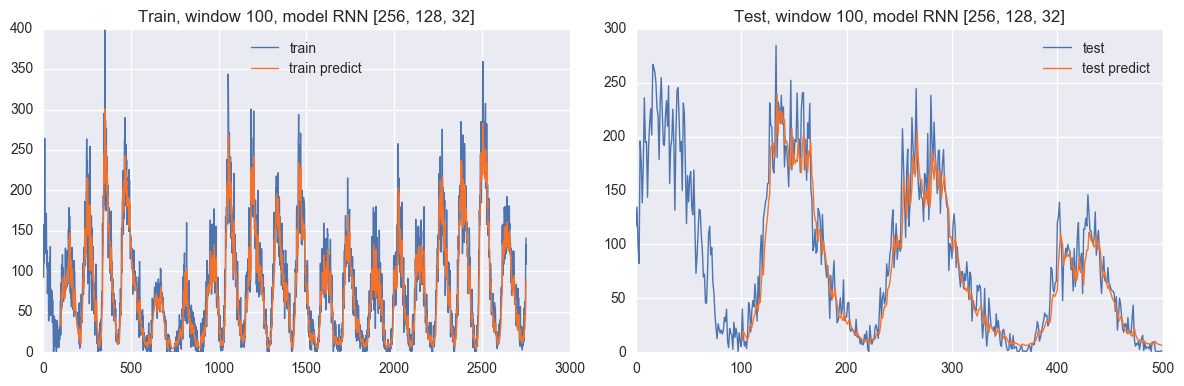

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 32)                4128      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 33        
Total para

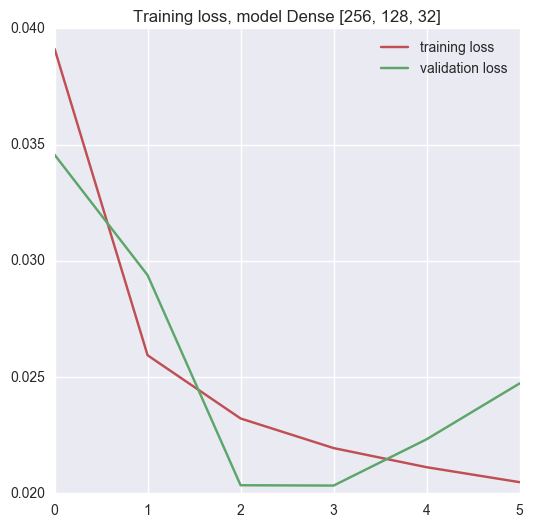

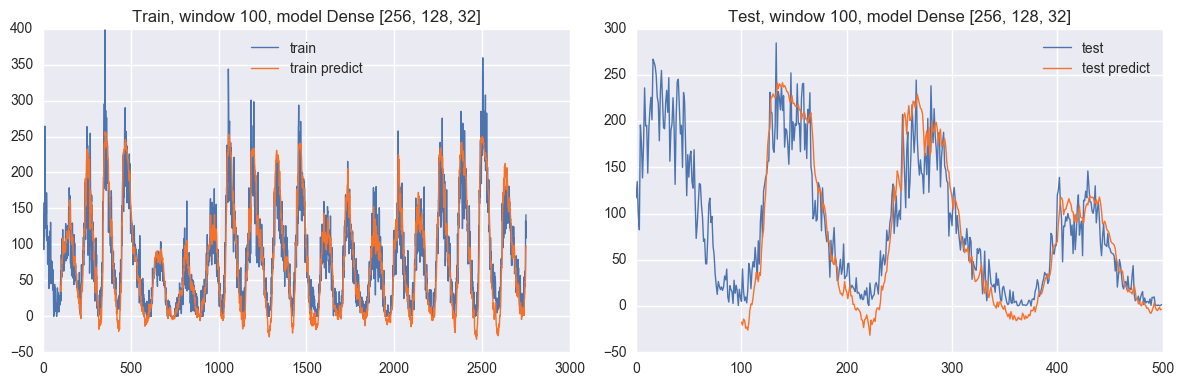

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 200, 256)          264192    
_________________________________________________________________
lstm_47 (LSTM)               (None, 200, 128)          197120    
_________________________________________________________________
lstm_48 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 33        
Total params: 481,953
Trainable params: 481,953
Non-trainable params: 0
_________________________________________________________________
Train on 1709 samples, validate on 843 samples
Epoch 1/50
1709/1709 [==============================] - 524s 307ms/step - loss: 0.0268 - acc: 0.0351 - val_loss: 0.0224 - val_acc: 0.0036
Epoch 2/50
1709/1709 [==============================] - 502s 293ms/step - loss: 0.0

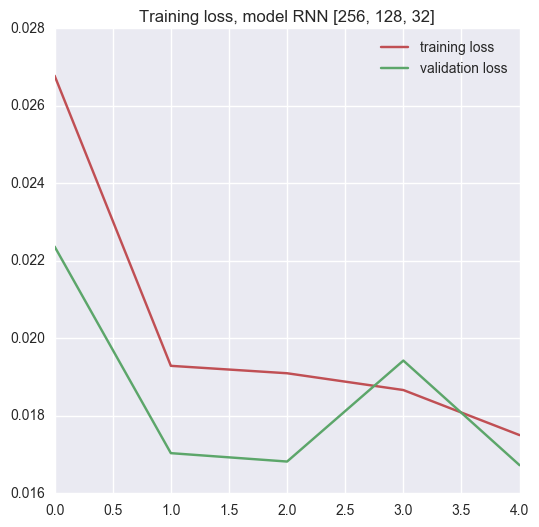

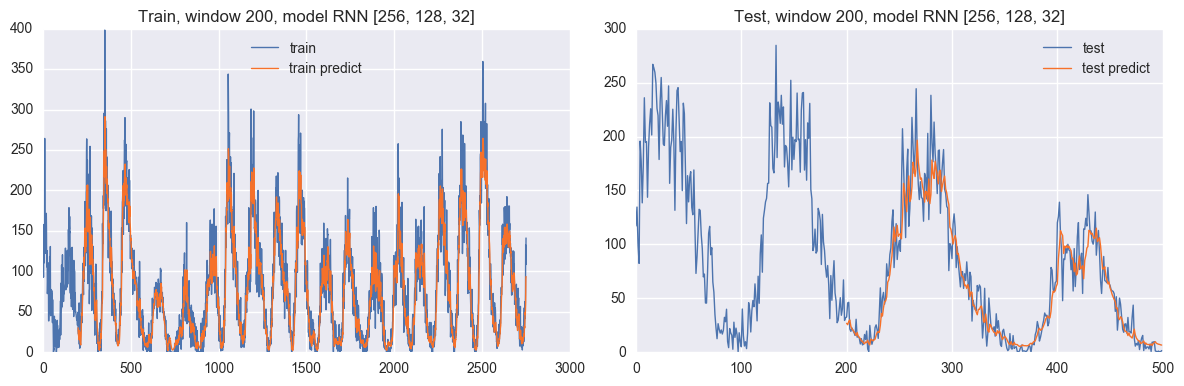

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 256)               51456     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 32)                4128      
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 33        
Total para

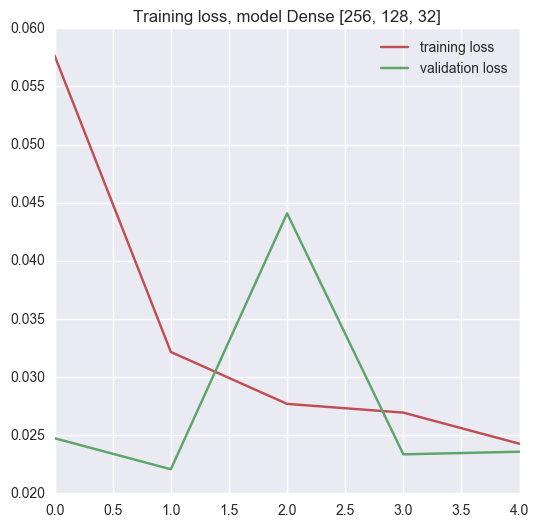

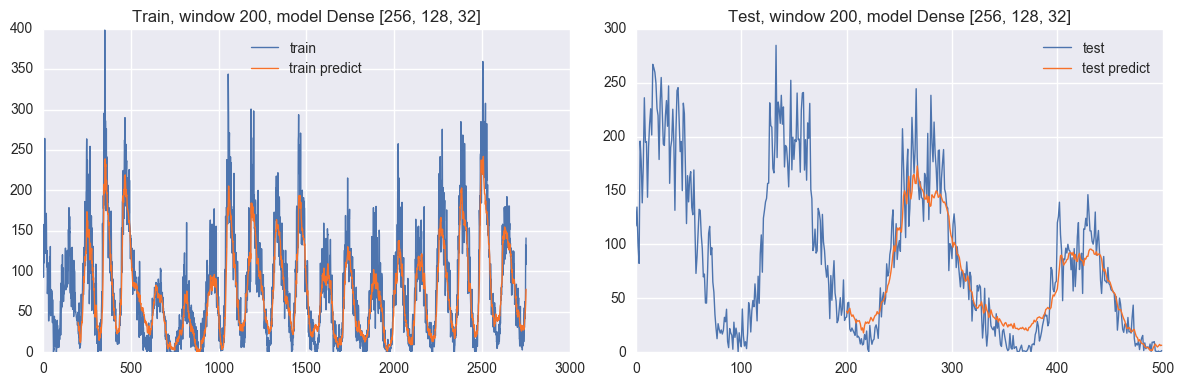

In [16]:
sines_num_epochs = 50 # Early stopping will usually bring a halt to this a lot sooner
spots_num_epochs = 200
sines_training_length = 500
spots_training_length = 2332
sines_model_shapes = [[3], [3,3], [3,3,3,3,3], [5], [5,5], [5,5,5,5,5], [10], [10,10], [10,10,10,10,10], [25], [25,25], [25,25,25,25,25]]
spots_model_shapes = [[3], [3,3], [3,3,3], [4, 2, 1], [256, 128, 32]]
sines_windows = [5, 10, 20]
spots_windows = [5, 50, 100, 200] 
sines_linewidth = 2
spots_linewidth = 1

data_source = 'spots'

num_epochs = sines_num_epochs
training_length = sines_training_length
model_shapes = sines_model_shapes
windows = sines_windows
linewidth = sines_linewidth
if data_source != 'sines':
    num_epocsh = spots_num_epochs
    training_length = spots_training_length
    model_shapes = spots_model_shapes
    windows = spots_windows
    linewidth = spots_linewidth

for units_list in model_shapes:
    for window_size in windows:
        for model_type in ['RNN', 'Dense']:
            filename = data_source+'-'+model_type+'-units-'+str(units_list)+'-window-'+str(window_size)+'.png'
            build_and_show(model_type, data_source, units_list=units_list, window_size=window_size, 
                           training_length=training_length, epochs=num_epochs, 
                           linewidth=linewidth, filename=filename)